## **EX 2 - Classifying the data :)**

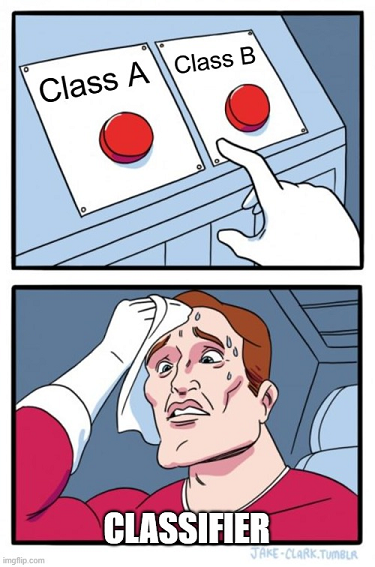

## These are important imports

In [348]:
# import sys
# if not (sys.version_info.major == 3 and sys.version_info.minor >= 6):
#     print("WARNING: OUTDATED PYTHON VERSION")
# !py -3.8 -m pip --version
# !py -3.8 -m pip install -r req.txt

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn

import matplotlib.pyplot as plt
import geopandas as gpd

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split 
from sklearn import metrics  
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from IPython.display import display, HTML

import re
from time import sleep
from random import choice, sample
from itertools import combinations
from math import pow

In [2]:
sb.set(color_codes=True, rc={'figure.figsize': (5, 5)})
COLUMNS_IS_CATEGORY = "is_software	is_web	is_mobile	is_enterprise	is_advertising	is_gamesvideo	is_ecommerce	is_biotech	is_consulting	is_othercategory".split('\t')
COLUMNS_IN_STATE = "in_CA	in_NY	in_MA	in_TX	in_otherstate".split('\t')
ROUNDS = "roundA	roundB	roundC	roundD".split('\t')

In [2]:
# PART 2 PARAMETERS
THE_P_VALUE = 0.05
NUM_OF_FOLDS = 5
RAND = 42

## 1) Pre-processing

### Reading the CSV file:

In [352]:
data_frame_train = pd.read_csv("../part-1/startup_dataset.csv")
data_frame_test = pd.read_excel("./test_data.xlsx")

dfs = {'train': data_frame_train, 'test': data_frame_test}


### Data cleaning - check for each one of the problems and take care of them properly, e.g., missing values,  inconsistent  etc. 

#### Missing values

In [353]:
def check_cleanness(df) -> None:
    are_all_good = True
    for title in df.columns:
        if df[title].isnull().sum() > 0:
            are_all_good = False
            print(f"titles {title} is {choice('dirty.smells.cheesy.ugly.stinky.boring'.split('.'))}")
    if are_all_good:
        print("Cleaning is done. All good!")

def create_country_col(df):
    for code in ['CA', 'NY', 'MA', 'TX', 'otherstate']:
        df.loc[df[f'in_{code}'] == 1, 'country'] = code

def fill_missing_vals(df):
    """
    fill missing values in country and first/last_milestone_age columns (same as part one)
    """
    # fill missing values in country column
    missing_country = df[df['country'].isnull()]
    for index in missing_country.index:
        state_code = df.loc[index, 'state_code']
        if state_code in ['CA', 'NY', 'MA', 'TX']:
            df.loc[index, 'country'] = state_code
        else:
            df.loc[index, 'country'] = 'otherstate'
    
    # fill missing values in the first/last_milestone_age columns
    null_indices = df['first_milestone_age'].isnull() | df['last_milestone_age'].isnull()

    features = ['first', 'last']
    for feature in features:
        df.loc[null_indices, f'{feature}_milestone_age'] = df.loc[~null_indices, f'{feature}_milestone_age'].min() - 10


    # df.loc[null_indices, 'first_milestone_age'] = df.loc[null_indices, 'last_milestone_age'] = -30
    # create a new column to indicate if the startup has milestones or not
    df.loc[null_indices, 'no_milestones'] = 1
    df.loc[~null_indices, 'no_milestones'] = 0

    print("All missing values are filled")


In [354]:
for df in dfs.values():
    create_country_col(df)

let's check which columns are dirty... (has missing values :\ )

In [355]:
for name, df in dfs.items():
    print(f"Before filling missing values - {name}")
    check_cleanness(df)
    print()

Before filling missing values - train
titles first_milestone_age is cheesy
titles last_milestone_age is cheesy
titles country is dirty

Before filling missing values - test
titles first_milestone_age is boring
titles last_milestone_age is ugly



Same as part one we can see that the columns: 'country', 'first_milestone_age', 'last_milestone_age' have missing values.   
So we will fill them - 'country' according to the state_code, and the other two with the mean of the column, and we will create a new column 'no_milestone' that will be 1 if there is no milestone and 0 otherwise - that is because the missing values in the 'first_milestone_age' and 'last_milestone_age' columns are because there is no milestone, so we want to keep this information.

In [356]:
for df in dfs.values():
    fill_missing_vals(df)

All missing values are filled
All missing values are filled


In [357]:
# let's check again
for name, df in dfs.items():
    print(f"After filling missing values - {name}")
    check_cleanness(df)
    print()

After filling missing values - train
Cleaning is done. All good!

After filling missing values - test
Cleaning is done. All good!



#### Inconsistent data

First we can check if the state_code is consistent with the in_(state_code) values in the data_frame_test, changing the in_(state_code) according to the state_code.

In [358]:
def check_binary_inconsistency(df, columns, label):
    association_word = columns[0][:2]
    for index in df[label].index:

        # x = data_frame_test.loc[index, columns].values#.sum()# == 1
        # x = next((col for (col, val) in zip(columns, x) if val==1)).strip("in_")
        category_code = df.loc[index, label].replace('_', '')
        good_code = f"{association_word}_{category_code}" if f"{association_word}_{category_code}" in columns else columns[-1]
    
        if df.loc[index, good_code] == 1:
            if df.loc[index, columns].values.sum() == 1:  # we have only one 1 :)
                continue
            else:  # we have more than one 1 :(
                df.loc[index, columns] = [0]*len(columns)
                df.loc[index, good_code] = 1  # save the good one

        else:  # we don't have a one in the good column
            print(f"wrong values at id={df.loc[index, 'id']}. fixing now...", end=" ")
            right_value = [0]*len(columns)
            right_value[columns.index(good_code)] = 1
            df.loc[index, columns] = right_value
            sleep(0.5)
            print("done.")
    
    print("All good! No more inconsistency.")

In [359]:
for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - state_code")
    check_binary_inconsistency(df, COLUMNS_IN_STATE, "state_code")
    print()

checking inconsistency in train data - state_code
wrong values at id=c:856. fixing now... done.
All good! No more inconsistency.

checking inconsistency in test data - state_code
All good! No more inconsistency.



As we stated before, we had one inconsistent value in the state_code column (we observed it thanks to the country column we added), so we changed it to the correct value.

Secondly, we can check if the category is consistent with the is_(category) values in the data_frame_test, changing the is_(category) according to the category.

In [360]:
for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - category")
    check_binary_inconsistency(df, COLUMNS_IS_CATEGORY, "category")
    print()

checking inconsistency in train data - category


All good! No more inconsistency.

checking inconsistency in test data - category
All good! No more inconsistency.



We can also check the cities for inconsistency - here we also use the code from part 1

In [361]:
for name, df in dfs.items():
    print(f"the cities in {name} data")
    x = np.sort(df["city"].unique())
    print("\n".join(x))
    print()

the cities in train data
Addison
Alameda
Albuquerque
Aliso Viejo
Allentown
Alpharetta
Andover
Annapolis
Arlington
Atlanta
Austin
Bala Cynwyd
Bedford
Bellevue
Belmont
Berkeley
Berwyn
Bethesda
Bethlehem
Beverly Hills
Billerica
Bingham Farms
Bloomfield
Boston
Bothell
Boulder
Boxborough
Brisbane
Brooklyn
Broomfield
Burlingame
Burlington
Calabasas
Cambridge
Campbell
Canton
Carlsbad
Carpinteria
Centennial
Champaign
Chantilly
Charlottesville
Chevy Chase
Chicago
Cincinnati
College Park
Columbia
Conshohocken
Cupertino
Dallas
Dedham
Denver
Dulles
Duluth
Durham
El Segundo
Emeryville
Englewood
Evanston
Farmington
Foster City
Framingham
Frederick
Freedom
Fremont
Glendale
Golden Valley
Greenwood Village
Hartford
Henderson
Herndon
Hillsborough
Hollywood
Indianapolis
Irvine
Itasca
Jersey City
Kansas City
Kearneysville
Kirkland
Lake Oswego
Larkspur
Las Vegas
Lawrenceville
Lexington
Lindon
Littleton
Long Island City
Longmont
Los Altos
Los Angeles
Los Gatos
Louisville
Loveland
Lowell
Manchester
Marlborou

We found some duplicates in the data (and typos :P), so we'll merge them into the same city.

In [362]:
def check_cities(df):
    """Check for and fix inconsistency in cities column"""
    # from part-1
    inconsistency_cities = {'New York City': "NYC.NY.New York", 'Atlanta': 'NW Atlanta',
    'Hollywood': 'North Hollywood.West Hollywood', 'Reading': "North Reading", "Billerica": "North Billerica",
    "Spokane": "SPOKANE", 'San Francisco': "San Franciso.South San Francisco", "Sunnyvale": "Sunnnyvale", "Chester": "West Chester", 
    "Hollywood": "West Hollywood", "Newfield": "West Newfield"}

    for key, values in inconsistency_cities.items():
        for fix_from in values.split('.'):
            df.loc[df['city']==fix_from, "city"] = key

    # new things from this part
    for index in df.index:
        df.loc[index, "city"] = re.sub(r'[^a-zA-Z ]+', '', df.loc[index, "city"])  # remove all non-alphabetic characters

    print("All good! No more inconsistency.")

for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - city")
    check_cities(df)
    print()

checking inconsistency in train data - city


All good! No more inconsistency.

checking inconsistency in test data - city
All good! No more inconsistency.



In [363]:
for name, df in dfs.items():
    print(f"The cities in {name} data - after fixing")
    x = np.sort(df["city"].unique())
    print("\n".join(x))
    print()

The cities in train data - after fixing
Addison
Alameda
Albuquerque
Aliso Viejo
Allentown
Alpharetta
Andover
Annapolis
Arlington
Atlanta
Austin
Bala Cynwyd
Bedford
Bellevue
Belmont
Berkeley
Berwyn
Bethesda
Bethlehem
Beverly Hills
Billerica
Bingham Farms
Bloomfield
Boston
Bothell
Boulder
Boxborough
Brisbane
Brooklyn
Broomfield
Burlingame
Burlington
Calabasas
Cambridge
Campbell
Canton
Carlsbad
Carpinteria
Centennial
Champaign
Chantilly
Charlottesville
Chester
Chevy Chase
Chicago
Cincinnati
College Park
Columbia
Conshohocken
Cupertino
Dallas
Dedham
Denver
Dulles
Duluth
Durham
El Segundo
Emeryville
Englewood
Evanston
Farmington
Foster City
Framingham
Frederick
Freedom
Fremont
Glendale
Golden Valley
Greenwood Village
Hartford
Henderson
Herndon
Hillsborough
Hollywood
Indianapolis
Irvine
Itasca
Jersey City
Kansas City
Kearneysville
Kirkland
Lake Oswego
Larkspur
Las Vegas
Lawrenceville
Lexington
Lindon
Littleton
Long Island City
Longmont
Los Altos
Los Angeles
Los Gatos
Louisville
Loveland
Lowe

All good now :)

We can also check if the funding ages are consistent with the funding dates and foundation dates (should be the difference between them).

In [364]:
def check_ages(df, age_col, date_col, ref_col):
    """Check if the age is consistent with the date according to the reference column"""
    # first we transform the date to a datetime object of pandas - this will help us to calculate the age :)
    df['foundation_date'] = pd.to_datetime(df['foundation_date'], format='%m/%d/%Y')
    df['first_funding_date'] = pd.to_datetime(df['first_funding_date'], format='%m/%d/%Y')
    df['last_funding_date'] = pd.to_datetime(df['last_funding_date'], format='%m/%d/%Y')

    for index in df[age_col].index:
        if df.loc[index, age_col] != round((df.loc[index, date_col] - df.loc[index, ref_col]).days / 365, 4):  # age need to be the difference between the dates
            print(f"wrong values fixing now... ", end=" ")
            df.loc[index, age_col] = round((df.loc[index, date_col] - df.loc[index, ref_col]).days / 365, 4)  # fix the age
            sleep(0.5)
            print("done.")
    print(f"All good! No more inconsistency in the {age_col} column.")

# now fix the first_funding_age and last_funding_age columns
for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - first_funding_age, last_funding_age")
    check_ages(df, 'first_funding_age', 'first_funding_date', 'foundation_date')
    check_ages(df, 'last_funding_age', 'last_funding_date', 'foundation_date')
    print()

checking inconsistency in train data - first_funding_age, last_funding_age


All good! No more inconsistency in the first_funding_age column.
All good! No more inconsistency in the last_funding_age column.

checking inconsistency in test data - first_funding_age, last_funding_age
All good! No more inconsistency in the first_funding_age column.
All good! No more inconsistency in the last_funding_age column.



We can also check the rounds for inconsistency - total funding rounds should be at least the sum of the other rounds.

In [365]:
def check_funding_rounds(df):
    """Check if the funding_rounds column is consistent with the other funding columns"""
    for index in df['funding_rounds'].index:
        if df.loc[index, ROUNDS].sum() > df.loc[index, 'funding_rounds']:
            print("wrong values fixing now... ", end=" ")
            df.loc[index, 'funding_rounds'] = df.loc[index, ROUNDS].sum()
            sleep(0.5)
            print("done.")

    print("All good! No more inconsistency in the funding_rounds column.")


for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - funding_rounds")
    check_funding_rounds(df)
    print()

checking inconsistency in train data - funding_rounds


All good! No more inconsistency in the funding_rounds column.

checking inconsistency in test data - funding_rounds
All good! No more inconsistency in the funding_rounds column.



#### Outliers

In [366]:
def find_outliers(df, col, positive=False):
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    good_lower_bound = max(0, lower_bound) if positive else lower_bound
    return good_lower_bound, upper_bound, df[(df[col] < good_lower_bound) | (df[col] > upper_bound)]  # return the outliers

def display_earth_outliers(outliers):
    world_countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    fig2, ax2 = plt.subplots(figsize=(8,5))
    countries_to_display = world_countries[world_countries['name']=='United Kingdom']

    countries_to_display.plot(color="lightgrey", ax=ax2)
    outliers.plot(x="longitude", y="latitude", kind="scatter", ax=ax2, cmap='rainbow', s=2)

outliers in train data
Outliers for total_funding:
	lower bound: 0
	upper bound: 662578420.2063695




Outliers for connections:
	lower bound: 0
	upper bound: 30.070518032500324




Outliers for funding_rounds:
	lower bound: 0
	upper bound: 6.4939842068953855




Outliers for milestones:
	lower bound: 0
	upper bound: 5.875562724515395




Outliers for avg_group_size:
	lower bound: 0
	upper bound: 8.280240356321517




Outliers in longitude


Outliers in latitude

outliers in test data
Outliers for total_funding:
	lower bound: 0
	upper bound: 88207858.52055818




Outliers for connections:
	lower bound: 0
	upper bound: 27.154728920709278




Outliers for funding_rounds:
	lower bound: 0
	upper bound: 6.453268331379396




Outliers for milestones:
	lower bound: 0
	upper bound: 5.538128423569414




Outliers for avg_group_size:
	lower bound: 0
	upper bound: 9.146915852031986




Outliers in longitude


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Outliers in latitude


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


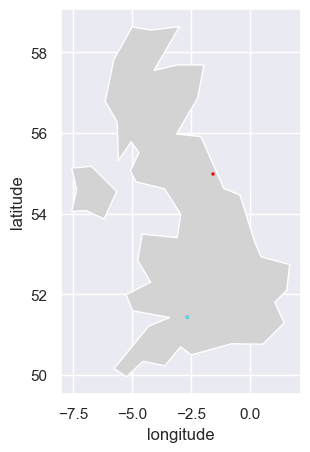

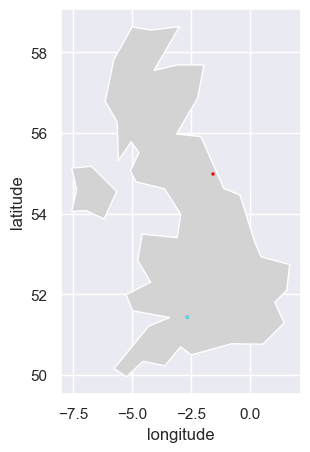

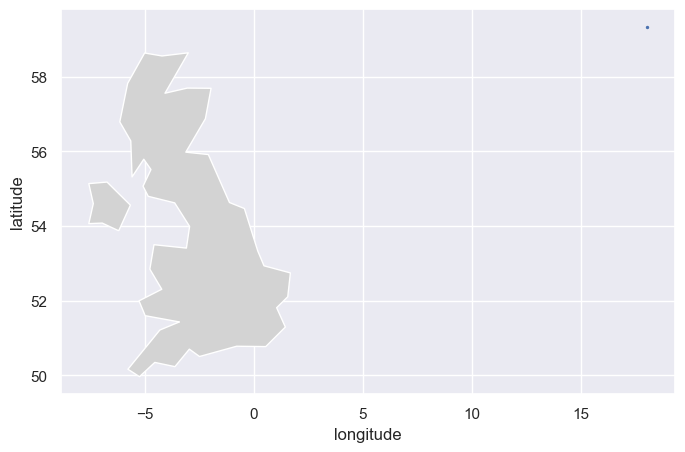

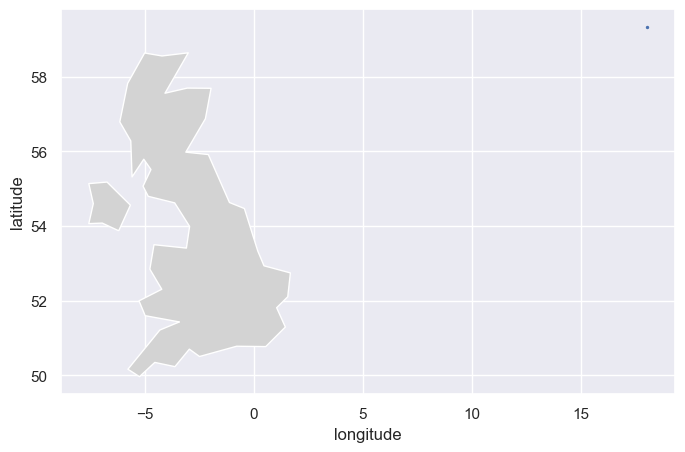

In [367]:
OUTLIERS_CHECK_COLS = ['total_funding', 'connections', 'funding_rounds', 'milestones', 'avg_group_size']

def print_outliers(df):
    """Print for outliers in the given dateframe"""
    for col in OUTLIERS_CHECK_COLS:
        l_bound, u_bound, outliers = find_outliers(df, col, col)
        print(f"Outliers for {col}:\n\tlower bound: {l_bound}\n\tupper bound: {u_bound}")
        display(HTML(outliers.to_html()))
        print("\n")
    
    print("Outliers in longitude")
    display_earth_outliers(df[df["longitude"]>-20])

    print("Outliers in latitude")
    display_earth_outliers(df[df["latitude"]>50])
    

for name, df in dfs.items():
    print(f"outliers in {name} data")
    print_outliers(df)
    print()

We don't have a lot of outliers so we will drop those rows

In [368]:
def drop_earth_outliers(df):
    return df[df['longitude']<=-20]

for name in dfs.keys():
    dfs[name] = drop_earth_outliers(dfs[name])

In [369]:
dfs['train']

id state_code   latitude   longitude zip_code           city  \
0      c:6669         CA  42.358880  -71.056820    92101      San Diego   
1     c:16283         CA  37.238916 -121.973718    95032      Los Gatos   
2     c:65620         CA  32.901049 -117.192656    92121      San Diego   
3     c:42668         CA  37.320309 -122.050040    95014      Cupertino   
4     c:65806         CA  37.779281 -122.419236    94105  San Francisco   
..        ...        ...        ...         ...      ...            ...   
733    c:5988         CA  37.536402 -122.325129    94403      San Mateo   
734   c:34549         NY  40.650104  -73.949582    11211       Brooklyn   
735   c:19538         WA  47.625740 -122.358162    98119        Seattle   
736   c:29605         PA  40.245664  -74.845997    19067        Yardley   
737  c:148139         CA  37.388869 -122.072353    94041  Mountain View   

                   name foundation_date first_funding_date last_funding_date  \
0           Bandsintown      2007-01-01         2009-04-01        2010-01-01   
1             TriCipher      2000-01-01         2005-02-14        2009-12-28   
2                 Plixi      2009-03-18         2010-03-30        2010-03-30   
3     Solidcore Systems      2002-01-01         2005-02-17        2007-04-25   
4        Inhale Digital      2010-08-01         2010-08-01        2012-04-01   
..                  ...             ...                ...               ...   
733     B-hive Networks      2005-01-01         2006-08-25        2006-08-25   
734          Hot Potato      2009-01-01         2009-11-25        2009-11-25   
735            Kashless      2008-09-01         2008-10-29        2011-02-04   
736  Three Screen Games      2009-01-01         2009-10-07        2009-10-07   
737          LaunchGram      2012-01-10         2012-01-23        2012-10-01   

     ...  is_othercategory  roundA  roundB  roundC  roundD  avg_group_size  \
0    ...                 1       0       0       0       0          1.0000   
1    ...                 0       0       1       1       1          4.7500   
2    ...                 0       1       0       0       0          4.0000   
3    ...                 0       0       1       1       1          3.3333   
4    ...                 0       0       0       0       0          1.0000   
..   ...               ...     ...     ...     ...     ...             ...   
733  ...                 0       1       0       0       0          2.0000   
734  ...                 1       1       0       0       0         16.0000   
735  ...                 0       1       0       0       0          1.0000   
736  ...                 0       0       0       0       0          1.0000   
737  ...                 1       0       0       0       0          1.0000   

     in_Top500    Target     country  no_milestones  
0            0  acquired          CA            0.0  
1            1  acquired          CA            0.0  
2            1  acquired          CA            0.0  
3            1  acquired          CA            0.0  
4            1    closed          CA            0.0  
..         ...       ...         ...            ...  
733          1  acquired          CA            1.0  
734          1  acquired          NY            0.0  
735          1    closed  otherstate            0.0  
736          1    closed  otherstate            1.0  
737          1  acquired          CA            0.0  

[735 rows x 43 columns]

### Data transformation -  apply  data  transformations  that  will  allow  better  analysis  and  visualizations,  e.g.,  normalization,  discretization  etc.

#### Discretization

We we'll do discretization for the connections, funding_rounds, milestones, avg_group_size and avg_group_size columns, because we saw that they have outliers and we want to take them into account.   
We can use reasoning partition for them, to divide them into "reasonable" groups, and group the outliers apart from the others.   
The bins were decided according to the distribution of the data and the outliers we saw before.

In [370]:
def discretize(df, col, bins):
    df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)
    print(df[f"{col}_bins"].value_counts())
    plt.title(f"{col}_bins")
    df[f"{col}_bins"].value_counts().sort_index().plot.bar()
    plt.show()

discretize train data
0    376
1    190
2    121
3     35
4     13
Name: connections_bins, dtype: int64


C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


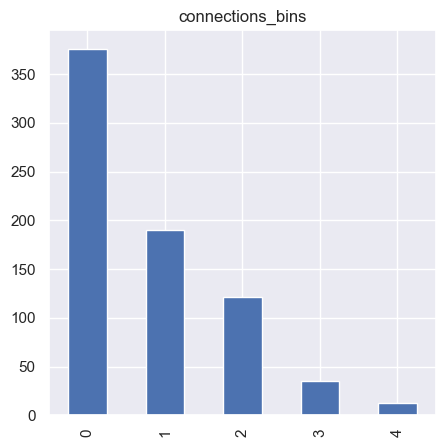

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


0    253
1    224
2    133
3     69
4     43
5     13
Name: funding_rounds_bins, dtype: int64


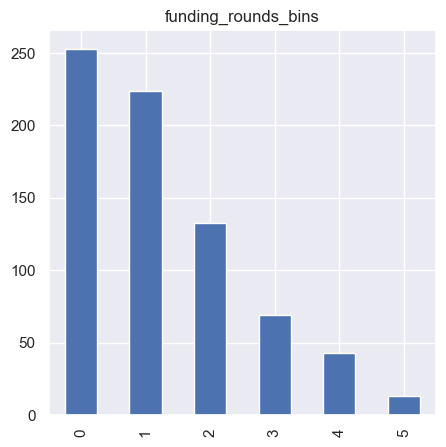

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


0    325
1    196
2    135
3     52
4     21
5      6
Name: milestones_bins, dtype: int64


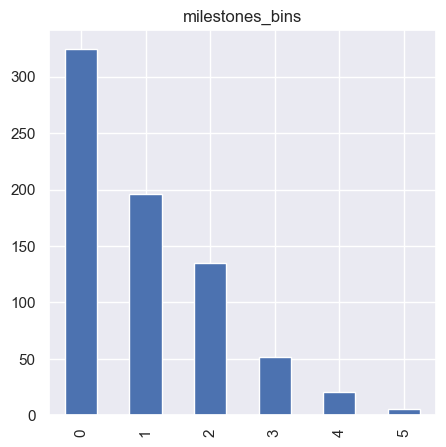

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


1    336
0    172
2    169
3     43
4     15
Name: avg_group_size_bins, dtype: int64


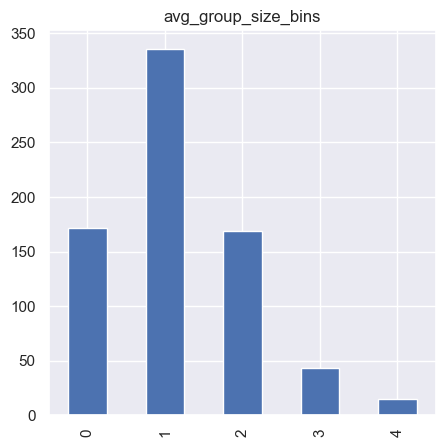

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\2014976260.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state_code_bins'] = df['country'].map({state: i for i, state in enumerate(df['country'].unique())})


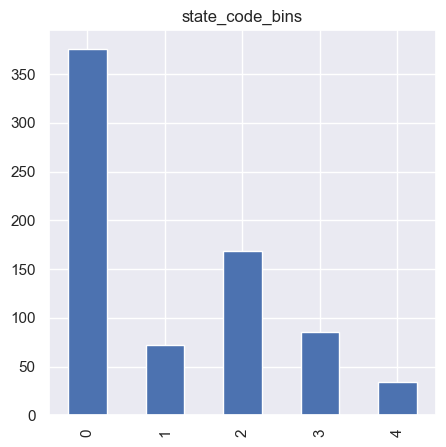

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\2014976260.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col]==1, 'category_1'] = col.strip("is_")
C:\Users\liri\AppData\Local\Temp\ipykernel_32648\2014976260.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_bins'] = df['category_1'].map({state: i for i, state in enumerate(df['category_1'].unique())})


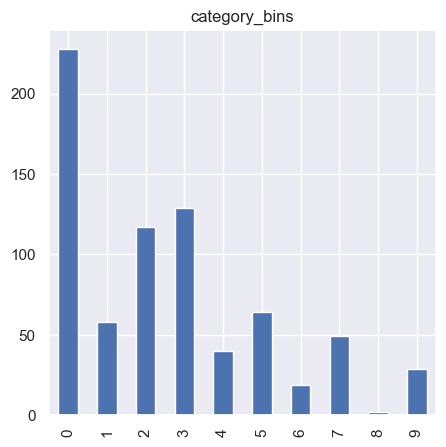


discretize test data
0    90
1    48
2    34
3    11
4     1
Name: connections_bins, dtype: int64


C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


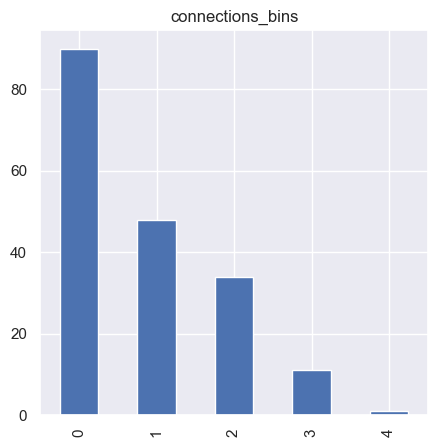

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


0    64
1    53
2    33
3    21
4    10
5     3
Name: funding_rounds_bins, dtype: int64


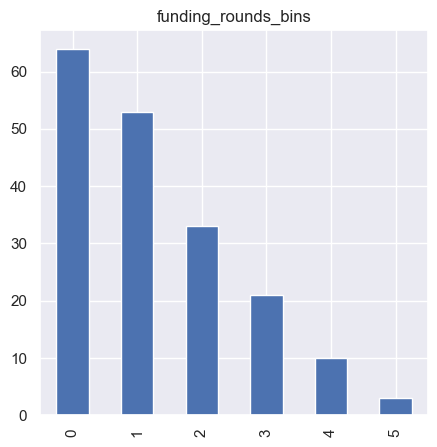

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


0    76
1    48
2    46
3    10
4     3
5     1
Name: milestones_bins, dtype: int64


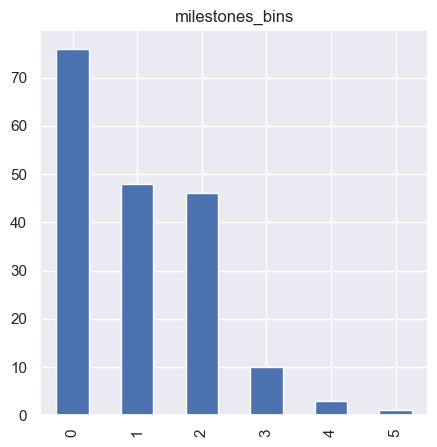

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\1395116043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)


1    85
0    44
2    29
3    21
4     5
Name: avg_group_size_bins, dtype: int64


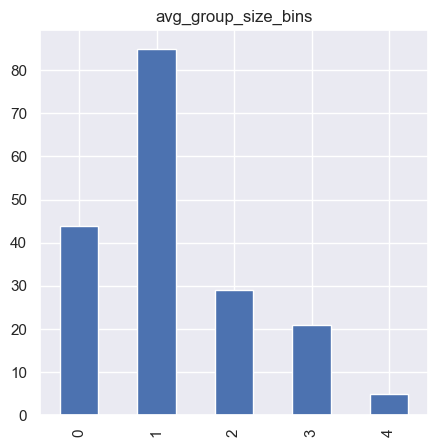

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\2014976260.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state_code_bins'] = df['country'].map({state: i for i, state in enumerate(df['country'].unique())})


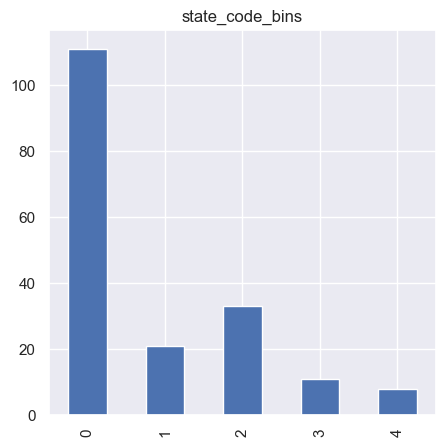

C:\Users\liri\AppData\Local\Temp\ipykernel_32648\2014976260.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col]==1, 'category_1'] = col.strip("is_")
C:\Users\liri\AppData\Local\Temp\ipykernel_32648\2014976260.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_bins'] = df['category_1'].map({state: i for i, state in enumerate(df['category_1'].unique())})


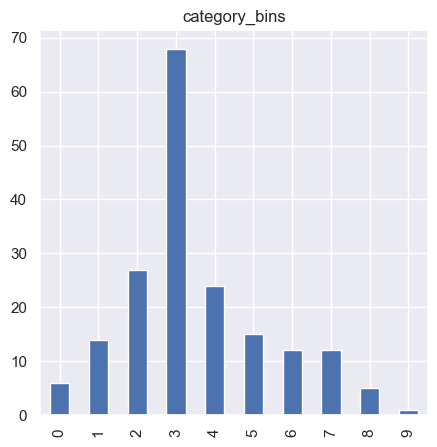

In [371]:
def discretize_and_plot(df):
    """discretize the data and plot the results"""
    connections = [0, 5, 10, 20, 30, df['connections'].max()]
    discretize(df, 'connections', connections)

    funding_rounds = [0, 1, 2, 3, 4, 6, df['funding_rounds'].max()]
    discretize(df, 'funding_rounds', funding_rounds)

    milestones = [0, 1, 2, 3, 4, 5, df['milestones'].max()]
    discretize(df, 'milestones', milestones)

    avg_group_size = [0, 1, 3, 5, 8, df['avg_group_size'].max()]
    discretize(df, 'avg_group_size', avg_group_size)

    df['state_code_bins'] = df['country'].map({state: i for i, state in enumerate(df['country'].unique())})
    plt.title('state_code_bins')
    df['state_code_bins'].value_counts().sort_index().plot.bar()
    plt.show()

    for col in COLUMNS_IS_CATEGORY:
        df.loc[df[col]==1, 'category_1'] = col.strip("is_")
    df['category_bins'] = df['category_1'].map({state: i for i, state in enumerate(df['category_1'].unique())})
    plt.title('category_bins')
    df['category_bins'].value_counts().sort_index().plot.bar()
    plt.show()

for name, df in dfs.items():
    print(f"discretize {name} data")
    discretize_and_plot(df)
    print()


### Drop columns

In [372]:
def drop_columns(df):
    """drop columns that are not needed"""
    df = df.copy()
    droppings = ['id', 'state_code', 'zip_code', 'city', 'name',
       'first_funding_date', 'last_funding_date', 'connections', 'funding_rounds', 
       'milestones', 'category', 'avg_group_size', 'avg_group_size', 
       'state_code_codes', 'category_codes', 'city_codes', 
       'country', 'in_Top500_str', 'category_1'] + COLUMNS_IN_STATE + COLUMNS_IS_CATEGORY  # and nominal data-s  + , 'latitude', 'longitude'
    return df.drop(set(droppings + ['no_milestones']) & set(df.columns), axis=1)

dfs_clean = {name: drop_columns(df) for name, df in dfs.items()}
for name, df in dfs_clean.items():
    print(f"Columns after dropping in {name} data")
    print(df.columns, end="\n\n")

Columns after dropping in train data
Index(['latitude', 'longitude', 'foundation_date', 'first_funding_age',
       'last_funding_age', 'first_milestone_age', 'last_milestone_age',
       'total_funding', 'roundA', 'roundB', 'roundC', 'roundD', 'in_Top500',
       'Target', 'connections_bins', 'funding_rounds_bins', 'milestones_bins',
       'avg_group_size_bins', 'state_code_bins', 'category_bins'],
      dtype='object')

Columns after dropping in test data
Index(['latitude', 'longitude', 'foundation_date', 'first_funding_age',
       'last_funding_age', 'first_milestone_age', 'last_milestone_age',
       'total_funding', 'roundA', 'roundB', 'roundC', 'roundD', 'in_Top500',
       'connections_bins', 'funding_rounds_bins', 'milestones_bins',
       'avg_group_size_bins', 'state_code_bins', 'category_bins'],
      dtype='object')



In [373]:
dfs_clean['train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 737
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   latitude             735 non-null    float64       
 1   longitude            735 non-null    float64       
 2   foundation_date      735 non-null    datetime64[ns]
 3   first_funding_age    735 non-null    float64       
 4   last_funding_age     735 non-null    float64       
 5   first_milestone_age  735 non-null    float64       
 6   last_milestone_age   735 non-null    float64       
 7   total_funding        735 non-null    int64         
 8   roundA               735 non-null    int64         
 9   roundB               735 non-null    int64         
 10  roundC               735 non-null    int64         
 11  roundD               735 non-null    int64         
 12  in_Top500            735 non-null    int64         
 13  Target               735 non-null  

In [374]:
dfs_clean['test'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 184
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   latitude             184 non-null    float64       
 1   longitude            184 non-null    float64       
 2   foundation_date      184 non-null    datetime64[ns]
 3   first_funding_age    184 non-null    float64       
 4   last_funding_age     184 non-null    float64       
 5   first_milestone_age  184 non-null    float64       
 6   last_milestone_age   184 non-null    float64       
 7   total_funding        184 non-null    int64         
 8   roundA               184 non-null    int64         
 9   roundB               184 non-null    int64         
 10  roundC               184 non-null    int64         
 11  roundD               184 non-null    int64         
 12  in_Top500            184 non-null    int64         
 13  connections_bins     184 non-null  

### Normalization

First we need to fix the date columns, because they are not in the correct format - not a number

In [375]:
# transform the data columns to be numeric, so we can normalize them :)
for name, df in dfs_clean.items():
    df['foundation_date'] = df['foundation_date'].astype('int64')
    print(f"=== Info of {name} ===")
    print(df.info())
    print()

=== Info of train ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 737
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   latitude             735 non-null    float64 
 1   longitude            735 non-null    float64 
 2   foundation_date      735 non-null    int64   
 3   first_funding_age    735 non-null    float64 
 4   last_funding_age     735 non-null    float64 
 5   first_milestone_age  735 non-null    float64 
 6   last_milestone_age   735 non-null    float64 
 7   total_funding        735 non-null    int64   
 8   roundA               735 non-null    int64   
 9   roundB               735 non-null    int64   
 10  roundC               735 non-null    int64   
 11  roundD               735 non-null    int64   
 12  in_Top500            735 non-null    int64   
 13  Target               735 non-null    object  
 14  connections_bins     735 non-null    category
 15  f

Before we'll normalize the column of the total_funding we need to fix the outlier in it, because they will affect the normalization!
In order to do that, we will replace the outlier that we found earlier with the upper bound of the outlier in the column.

In [376]:
def fix_out_total_funding(df):
    """Fix the total_funding column in the given dataframe"""
    lb, ub, o = find_outliers(df=df, col='total_funding')
    row = o.index.tolist()
    df.loc[row, 'total_funding'] = ub

In [377]:
for df in dfs_clean.values():
    fix_out_total_funding(df)

In [378]:
def normalize(data_f: pd.DataFrame, col_name: str) -> None:
    min_max_scaler = MinMaxScaler()  # min-max scaler normalizer between 0 and 1 :)
    min_max_scaler.fit(pd.DataFrame(data_f[col_name]))
    data_f[col_name] = min_max_scaler.transform(pd.DataFrame(data_f[col_name]))

def normalize_df(df):
    for col in df.columns:  # normalize all the columns that are not binary and not bins
        if df[col].nunique() > 2 and "_bins" not in col:  # check if not-binary and not bins
            normalize(df, col)

for name, df in dfs_clean.items():
    print(f"Normalize {name} data...", end="\t")
    normalize_df(df)
    print("done.")

Normalize train data...	done.
Normalize test data...	done.


Finally we will transform the Target column to 0 and 1, according to the value of the column (1 if the company was acquired, 0 if closed).

In [379]:
dfs_clean['train'].loc[dfs_clean['train']['Target'] == 'acquired', 'Target'] = 1
dfs_clean['train'].loc[dfs_clean['train']['Target'] == 'closed', 'Target'] = 0

# transform the target column to be numeric
dfs_clean['train']['Target'] = dfs_clean['train']['Target'].astype('int64')

In [380]:
dfs_clean['train'].head()

latitude  longitude  foundation_date  first_funding_age  last_funding_age  \
0  0.750988   0.982652         0.785287           0.365061          0.389409   
1  0.515189   0.014887         0.546270           0.458030          0.615461   
2  0.315410   0.105759         0.860722           0.325749          0.325749   
3  0.518938   0.013436         0.614601           0.393572          0.464142   
4  0.540076   0.006419         0.907553           0.292368          0.346291   

   first_milestone_age  last_milestone_age  total_funding  roundA  roundB  \
0             0.590288            0.533779       0.000547       0       0   
1             0.638124            0.541594       0.060385       0       1   
2             0.524563            0.417135       0.003898       1       0   
3             0.617597            0.515592       0.060235       0       1   
4             0.495515            0.360945       0.001940       0       0   

   roundC  roundD  in_Top500  Target connections_bins funding_rounds_bins  \
0       0       0          0       1                0                   2   
1       1       1          1       1                1                   3   
2       0       0          1       1                0                   0   
3       1       1          1       1                0                   2   
4       0       0          1       0                0                   1   

  milestones_bins avg_group_size_bins  state_code_bins  category_bins  
0               2                   0                0              0  
1               0                   2                0              1  
2               1                   2                0              2  
3               0                   2                0              3  
4               0                   0                0              4

In [381]:
dfs_clean['train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 737
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   latitude             735 non-null    float64 
 1   longitude            735 non-null    float64 
 2   foundation_date      735 non-null    float64 
 3   first_funding_age    735 non-null    float64 
 4   last_funding_age     735 non-null    float64 
 5   first_milestone_age  735 non-null    float64 
 6   last_milestone_age   735 non-null    float64 
 7   total_funding        735 non-null    float64 
 8   roundA               735 non-null    int64   
 9   roundB               735 non-null    int64   
 10  roundC               735 non-null    int64   
 11  roundD               735 non-null    int64   
 12  in_Top500            735 non-null    int64   
 13  Target               735 non-null    int64   
 14  connections_bins     735 non-null    category
 15  funding_rounds_bins  73

In [382]:
dfs_clean['test'].head()

latitude  longitude  foundation_date  first_funding_age  last_funding_age  \
0  0.333033   0.105300         0.628663           0.130158          0.157181   
1  0.374937   0.081186         0.701841           0.401533          0.354502   
2  0.545850   0.005242         0.677342           0.125193          0.107546   
3  0.545443   0.004944         0.877342           0.182492          0.118247   
4  0.556428   0.002990         0.760448           0.484776          0.444287   

   first_milestone_age  last_milestone_age  total_funding  roundA  roundB  \
0             0.000000            0.000000       0.009560       1       0   
1             0.720855            0.790817       0.170799       0       0   
2             0.621757            0.660088       0.035769       1       0   
3             0.663704            0.681719       0.062547       1       0   
4             0.731123            0.702685       0.120333       1       0   

   roundC  roundD  in_Top500 connections_bins funding_rounds_bins  \
0       0       0          1                0                   1   
1       0       0          1                1                   0   
2       0       0          1                2                   1   
3       0       0          1                1                   0   
4       0       0          0                1                   0   

  milestones_bins avg_group_size_bins  state_code_bins  category_bins  
0               0                   0                0              0  
1               1                   0                0              1  
2               1                   4                0              2  
3               1                   3                0              0  
4               0                   0                0              3

In [383]:
dfs_clean['test'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 184
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   latitude             184 non-null    float64 
 1   longitude            184 non-null    float64 
 2   foundation_date      184 non-null    float64 
 3   first_funding_age    184 non-null    float64 
 4   last_funding_age     184 non-null    float64 
 5   first_milestone_age  184 non-null    float64 
 6   last_milestone_age   184 non-null    float64 
 7   total_funding        184 non-null    float64 
 8   roundA               184 non-null    int64   
 9   roundB               184 non-null    int64   
 10  roundC               184 non-null    int64   
 11  roundD               184 non-null    int64   
 12  in_Top500            184 non-null    int64   
 13  connections_bins     184 non-null    category
 14  funding_rounds_bins  184 non-null    category
 15  milestones_bins      18

In [384]:
for n, m in dfs_clean.items():
    m.to_csv(f'data_frame_{n}_clean.csv', index=False)

## 2) Classification, evaluation matrices and hyper-parameters

Load data for part 2 from CSV, in order to not run PART 1 again.

In [3]:
dfs_clean = {'train': None, 'test': None}
for n in dfs_clean.keys():
    dfs_clean[n] = pd.read_csv(f'data_frame_{n}_clean.csv')
df_train_clean = dfs_clean['train'].copy()
df_test_clean = dfs_clean['test'].copy()

### Some functions we will use later :)

In [4]:
"""
    Evaluates a classification model clf, after training it on data X, y
    the evaluation is done using K-folds: split into train-test and measure metrics
    
    Metrics which are calculated: Confusion table, Accuracy, Recall, Precision & F-Score
"""
def evaluate(X, y, clf):
    X = X.to_numpy()
    kf = KFold(n_splits=NUM_OF_FOLDS, shuffle=True, random_state=RAND)
    our_metrics = {'cm': [[], []], 'accuracy': [[], []], 'recall': [[], []], 'precision': [[], []], 'f-score': [[], []]}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for i, (curr_x, curr_y) in enumerate([(X_train, y_train), (X_test, y_test)]):
            clf.fit(X_train, y_train)
            y_pred = clf.predict(curr_x)
            our_metrics['cm'][i].append(metrics.confusion_matrix(curr_y, y_pred))
            our_metrics['accuracy'][i].append(metrics.accuracy_score(curr_y, y_pred))
            our_metrics['recall'][i].append(metrics.recall_score(curr_y, y_pred, average='weighted'))
            our_metrics['precision'][i].append(metrics.precision_score(curr_y, y_pred, average='weighted'))
            our_metrics['f-score'][i].append(metrics.f1_score(curr_y, y_pred))
    return our_metrics


"""
    Prints the different metrics
"""
def print_metrics(our_metrics):
    groups = ['train', 'test']
    results = {g: {m: val[idx] for m, val in our_metrics.items()}
               for idx, g in enumerate(groups)}
    
 
    confusion_metrices = {g: our_metrics['cm']
                   for idx, g in enumerate(groups)}
    accs = {g: our_metrics['accuracy']
                   for idx, g in enumerate(groups)}
    best_cm_index = np.argmax(results['test']['accuracy'])
    best_cm = results['test']['cm'][best_cm_index]
    print("Confusion table of (test) best fold:")
    # conf_pd = pd.DataFrame(best_cm)
    display(pd.DataFrame(best_cm))
    # print(best_cm)
        
    
#     results2 = {
#         'train': {
#             'Accuracy': our_metrics['accuracy'][0],
#             'Recall': our_metrics['recall'][0],
#             'Precision': our_metrics['precision'][0],
#             'F-score': our_metrics['f-score'][0] },
#         'test': {
#             'Accuracy': our_metrics['accuracy'][1],
#             'Recall': our_metrics['recall'][1],
#             'Precision': our_metrics['precision'][1],
#             'F-score': our_metrics['f-score'][1] }
#     }
    for group_name, group_metrics in results.items():
        group_metrics.pop('cm', None)
        print(f"Metrics for {group_name} set:")
        results_df = pd.DataFrame(group_metrics)
        mean_results = results_df.mean().to_frame().T
        mean_results.index = ['Mean']
        results_df = pd.concat([results_df, mean_results])
        results_df.index.name = '#Fold'
        # results_df = results_df.append(mean_results)
        display(HTML(results_df.to_html()))

        
# Splits Target column of DF into X, y
def split_train_result(df):
    X = df.drop(columns='Target')
    y = df['Target']
    return X, y


# adds dummy columns to DF where there are a few different values
def create_dummies(df):
    dummies_col = []
    for col in df:
        unique_values = len(df[col].unique())
        if 2 < unique_values < 8:
            dummies_col.append(col)

    return pd.get_dummies(data=df, columns=dummies_col)


def plot_hyper_search(hyper_search_models, x_axis_name):
    for name, model in hyper_search_models.items():
        test_scores = model.cv_results_['mean_test_score']
        param_values = list(model.cv_results_[f"param_{x_axis_name.replace(' ', '_')}"])
        # print(test_scores)

        plt.scatter(param_values, test_scores, label=f'{name} test')
    plt.xlabel(x_axis_name)
    plt.ylabel('Test Accuracy')
    plt.title(f'Score vs {x_axis_name}')
    plt.legend()

In [39]:
# only get accuracy of a model based on train & test DFs
def calc_accuracy(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)


# compares accuracy of two models, prints their difference
def compare_accuracy(X_train, y_train, X_test, y_test, model1, model2):
    accuracies = []
    for model in (model1, model2):
        clf = model[0]
        name = model[1]
        
        accuracy = calc_accuracy(X_train, y_train, X_test, y_test, clf)
        accuracies.append(accuracy)
        acc_percent = accuracy*100
        print(f"[{name}] model accuracy = {acc_percent:0.2f}%")
        
    improvment_factor = 100 * (accuracies[1] - accuracies[0]) / accuracies[0]
    print(f'Improvement of {improvment_factor:0.2f}%')


def createROC(X_train, y_train, X_test, y_test, models, plot=True):
    plt.figure(figsize=(8, 6))
    aucs = {}
    
    for model in models:
        name = model[1]
        model = model[0]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, ths = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        
        if plot:
            plt.plot(fpr, tpr, label=f'{name} model (AUC = {auc:0.2f})')

        aucs[name] = auc
    
    if plot:
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend()
        plt.show()
    return aucs


def ttest_score(model1_metric, model2_metric):
    """
        returns: 1 = model1 is better
                0 = no bias
                -1 = model2 is better
        and the p-value
    """
    if model1_metric == model2_metric:
        return 0, None
    
    ttest, pval = stats.ttest_rel(model1_metric, model2_metric)
    if pval < THE_P_VALUE:
        if model1_metric > model2_metric:
            return 1, pval
        else:
            return -1, pval
    else:
           return 0, pval


def ttest_print(model1_metric, model2_metric, model1_name, model2_name):
    result, pval = ttest_score(model1_metric, model2_metric)
    prefix = f"[{pval=:.3f}]" if pval is not None else "No p-value"
    if result == 0:
        print(prefix + f" accept null hypothesis => No one of {model1_name} and {model2_name} is better than the other")
    elif result == 1:
        print(prefix + f" reject null hypothesis => {model1_name} is BETTER THAN {model2_name}")
    elif result == -1:
        print(prefix + f" reject null hypothesis => {model2_name} is BETTER THAN {model1_name}")
    return result, pval


def ttest_all_metrics(all_models_metrics):
    metrics_names = ['accuracy', 'recall', 'precision', 'f-score']  # do we need to add auc? or the roc is enough?
    combs = list(combinations(all_models_metrics.items(), 2))
    
    # check ttest of each metric and each pair of model trees
    for (n1, m_dict1), (n2, m_dict2) in combs:
        models, metrics, scores = [], [], []
        for metric in metrics_names:
            print(f"T-test on metric {metric}", end="\t")
            model1_metric, model2_metric = m_dict1[metric][1], m_dict2[metric][1]
            result, pval = ttest_print(model1_metric, model2_metric, n1, n2)

            models.append(n1)
            models.append(n2)
            metrics.append(metric)
            metrics.append(metric)
            x = (result + 1)/2
            scores.append(x)
            scores.append(1-x)
            
        dict1 = {'Model': models, 'Metric': metrics, 'Score': scores}
        compare_df = pd.DataFrame(data=dict1).pivot(index="Model", columns="Metric", values="Score")
        f, ax = plt.subplots(figsize=(10, 1))
        
        ax = sb.heatmap(compare_df, annot=True, vmin=0, vmax=1, center=0.5, cmap=[(1, 0, 0), (0.5, 0.5, 0.5), (0, 1, 0)], linewidths=0.01, linecolor='white')

In [6]:
X, y = split_train_result(df_train_clean)
dummies_df = create_dummies(df_train_clean)
Xd, Yd = split_train_result(dummies_df)

### Check balance of data

In [7]:
def display_target_distribution(df):
    X, y = split_train_result(df)

    map = {0: "Closed", 1: "Acquired"}
    vals_tmp = y.value_counts()
    vals = np.array([vals_tmp[x] for x in map.keys()], dtype=int)
    lbls = [y for y in map.values()]

    # from https://stackoverflow.com/questions/41088236
    def absolute_value(val):
        return f"{val:1.1f}%\n{np.round(val/100.*vals.sum(), 0).astype(int)}"
    _ = plt.pie(vals, labels=lbls, autopct=absolute_value) # '%1.1f%    %'
    
    y.value_counts()


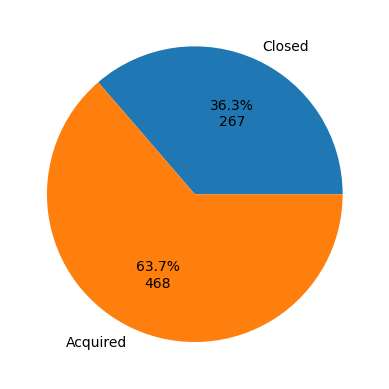

In [8]:
display_target_distribution(df_train_clean)

We see that the data is imbalanced! This can lead to a bias towards the Acquired target in prediction.
To fix this we will use SMOTE:

In [9]:
smote_oversampler = SMOTE(random_state=RAND, k_neighbors=8)
smote_X, smote_y = smote_oversampler.fit_resample(X, y)

# combine smote_X & smote_y into one dataframe
smote_df = smote_X.copy()
smote_df['Target'] = smote_y
smote_df.head()

latitude  longitude  foundation_date  first_funding_age  last_funding_age  \
0  0.750988   0.982652         0.785287           0.365061          0.389409   
1  0.515189   0.014887         0.546270           0.458030          0.615461   
2  0.315410   0.105759         0.860722           0.325749          0.325749   
3  0.518938   0.013436         0.614601           0.393572          0.464142   
4  0.540076   0.006419         0.907553           0.292368          0.346291   

   first_milestone_age  last_milestone_age  total_funding  roundA  roundB  \
0             0.590288            0.533779       0.000547       0       0   
1             0.638124            0.541594       0.060385       0       1   
2             0.524563            0.417135       0.003898       1       0   
3             0.617597            0.515592       0.060235       0       1   
4             0.495515            0.360945       0.001940       0       0   

   roundC  roundD  in_Top500  connections_bins  funding_rounds_bins  \
0       0       0          0                 0                    2   
1       1       1          1                 1                    3   
2       0       0          1                 0                    0   
3       1       1          1                 0                    2   
4       0       0          1                 0                    1   

   milestones_bins  avg_group_size_bins  state_code_bins  category_bins  \
0                2                    0                0              0   
1                0                    2                0              1   
2                1                    2                0              2   
3                0                    2                0              3   
4                0                    0                0              4   

   Target  
0       1  
1       1  
2       1  
3       1  
4       0

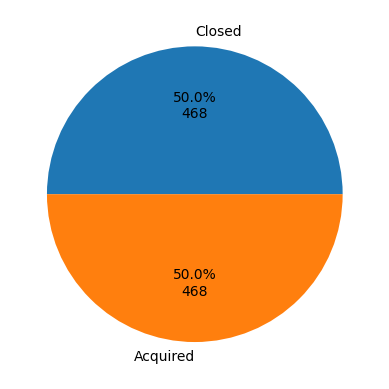

In [10]:
display_target_distribution(smote_df)

Now that the data is **balanced,** we will start looking for the best classification model. First we'll split the cleaned train data into X and Y (regular and dummy):

### [A] Decision Tree Classifier

In [11]:
def findBestDepth(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    for k in range(2, 25):
        clf = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                            max_depth=k, min_samples_split=15, min_samples_leaf=5, random_state=RAND)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(range(2,25), train_scores)
    plt.plot(range(2,25), test_scores)
    plt.xticks(range(2,25))
    plt.legend(['train', 'test'])
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.show()
    
    return np.argmax(test_scores) + 2, test_scores[np.argmax(test_scores)]

In [12]:
def presentTree(tree, X):
    dot = export_graphviz(tree, filled=True, rounded=True, special_characters=True, feature_names = X.columns, class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot)  
    display(Image(graph.create_png()))

Check the classic Decision Tree Classifier on our data split to train and validation set.

In [13]:
base_tree_model = DecisionTreeClassifier(random_state=RAND)

In [14]:
print_metrics(evaluate(X, y, base_tree_model))

Confusion table of (test) best fold:


0   1
0  37  15
1  16  79

Metrics for train set:


Metrics for test set:


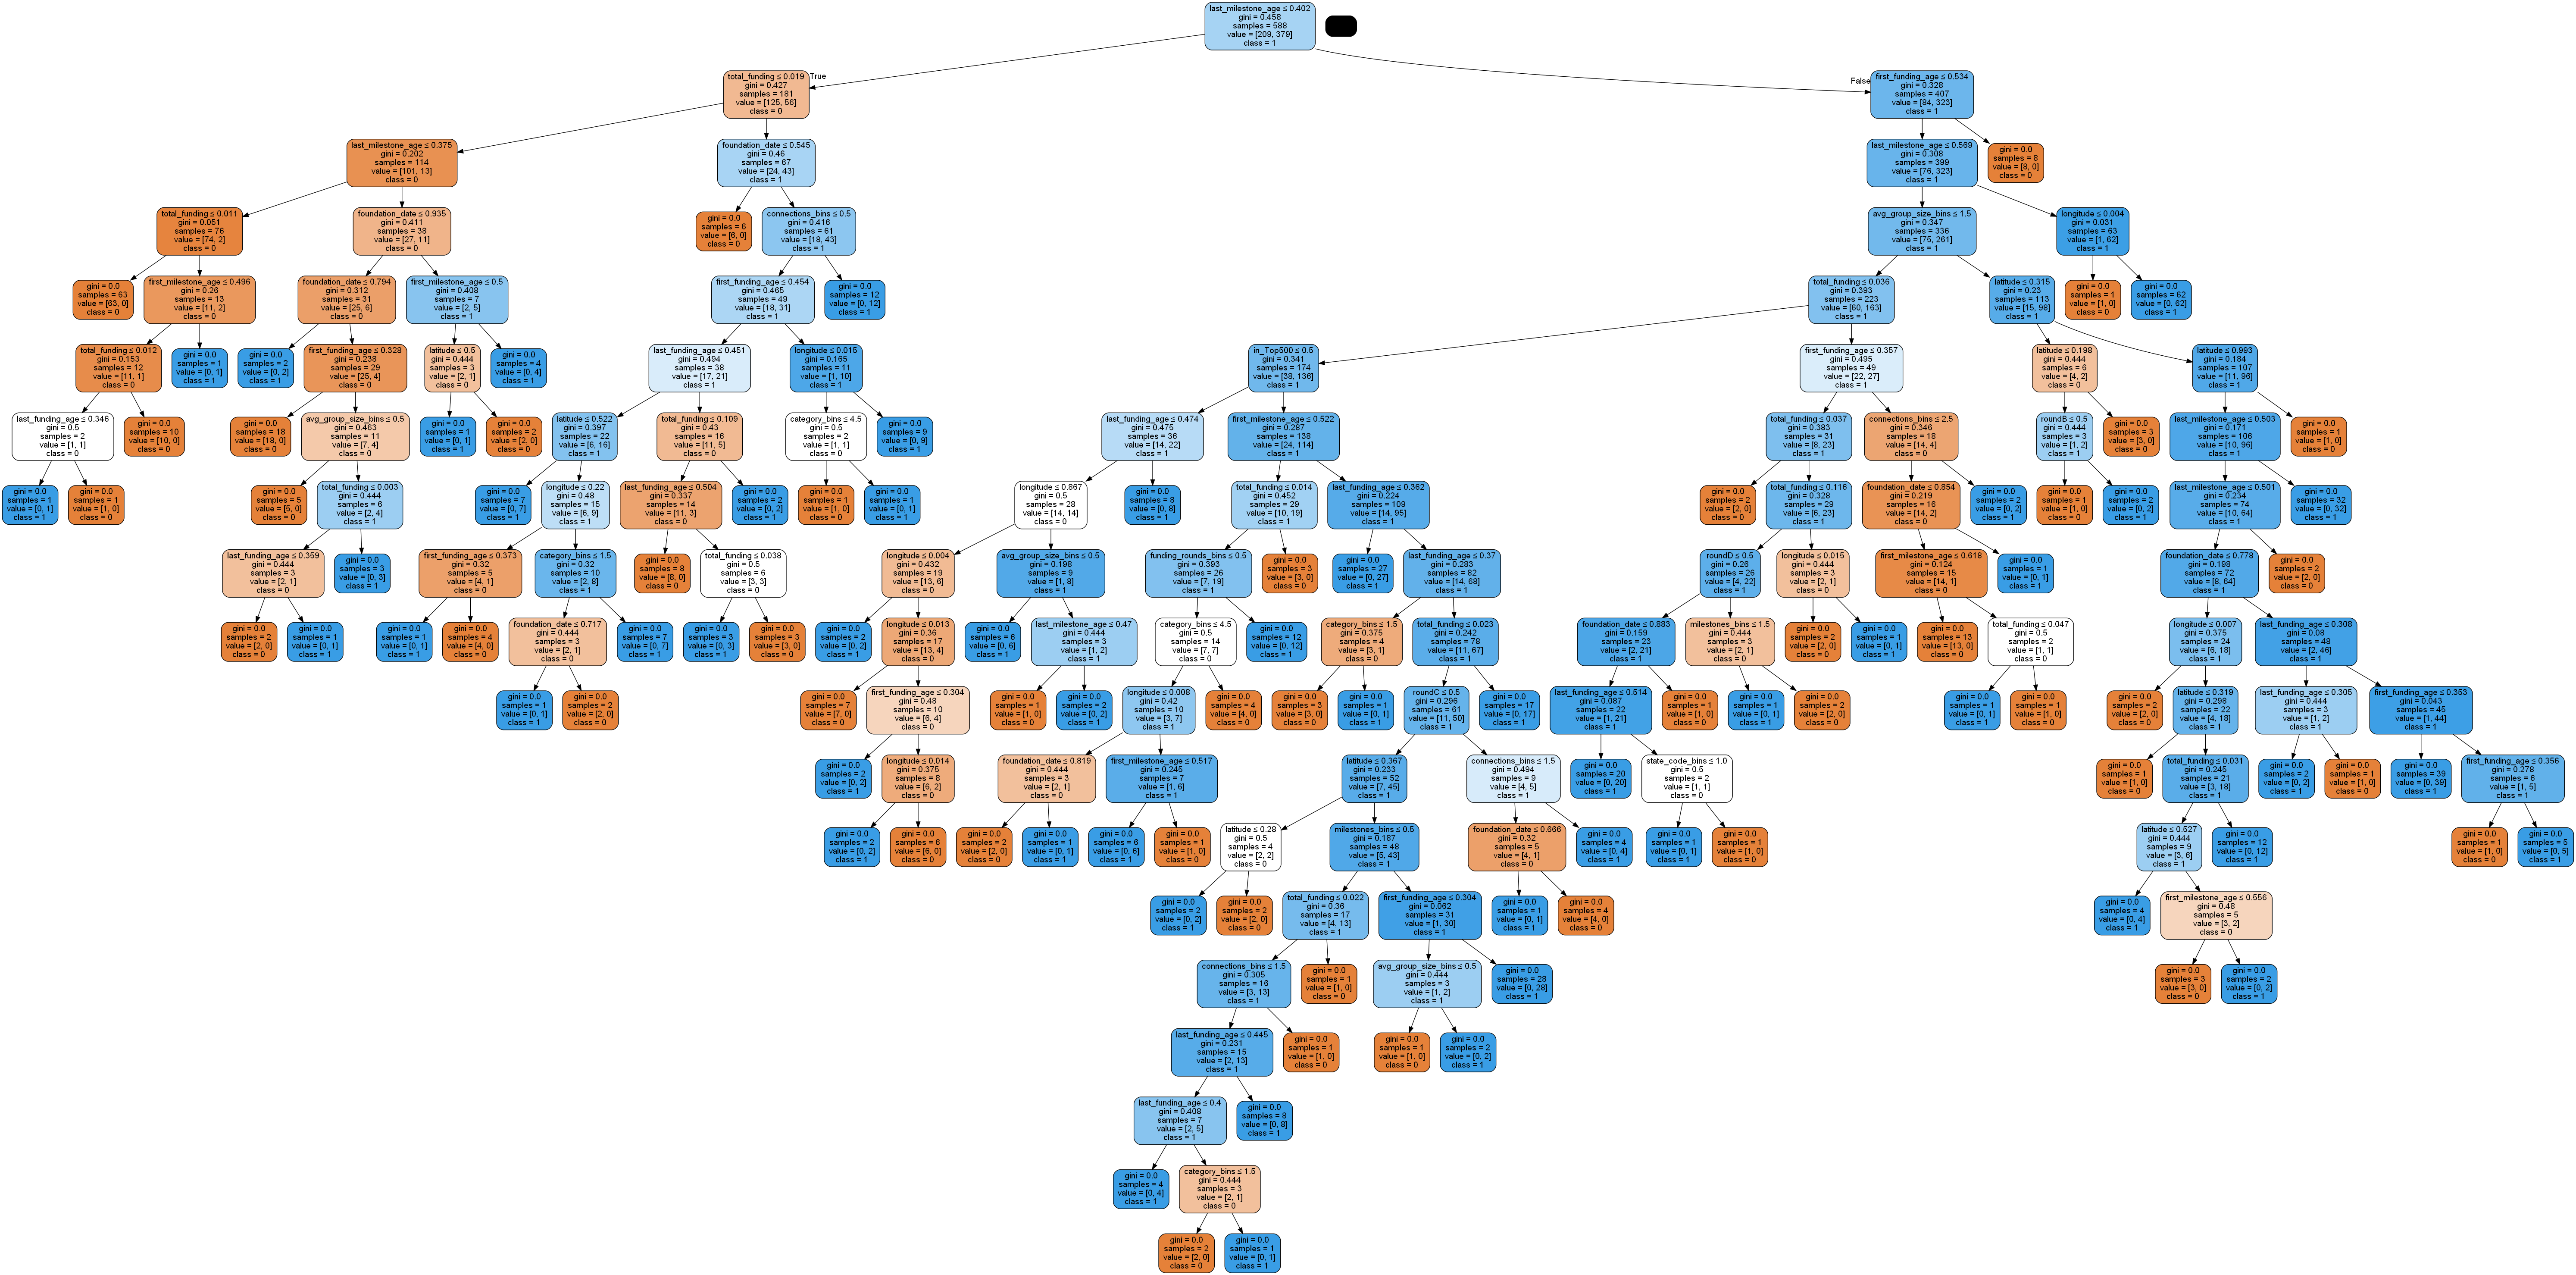

In [15]:
presentTree(base_tree_model, X)

We can see that the accuracy is not so good and we've got overfitting, so we'll try to improve it, by finding the best depth for the tree.

Split the data and check the accuracy of the decision tree model on the validation set - find the best depth for the tree.

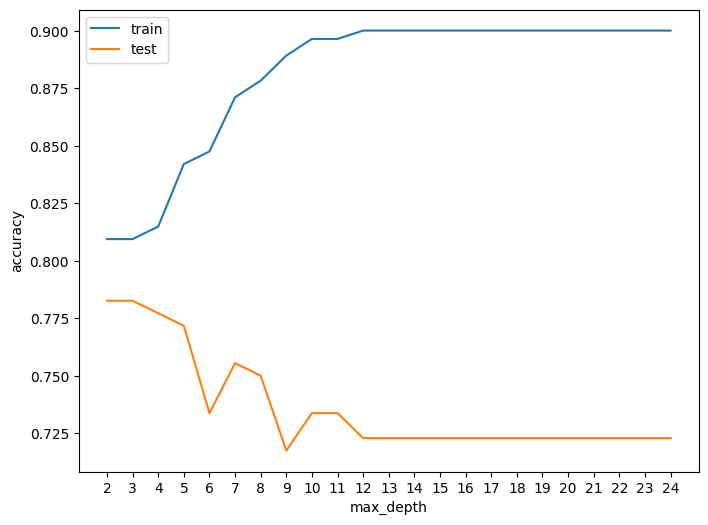

The best depth is 2 with accuracy of 0.782608695652174


In [16]:
best_depth, best_depth_acc = findBestDepth(X, y)
print(f'The best depth is {best_depth} with accuracy of {best_depth_acc}')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
best_tree_model = DecisionTreeClassifier(criterion='entropy', splitter='best',
                            max_depth=best_depth, min_samples_split=15, min_samples_leaf=5, random_state=RAND)
best_tree_model.fit(X_train, y_train)
print('best tree model: accuracy =', best_tree_model.score(X_test, y_test))

best tree model: accuracy = 0.782608695652174


We'll use the best depth we found for the decision tree model.

In [18]:
best_depth_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=best_depth, min_samples_split=15, min_samples_leaf=5, random_state=RAND)
print_metrics(evaluate(X, y, clf=best_depth_clf))

Confusion table of (test) best fold:


0   1
0  29  23
1   4  91

Metrics for train set:


Metrics for test set:


We can see that now we don't have overfitting and the accuracy of the test (of the cross validation) is better.

Let's run the base model on the balanced data

In [19]:
print_metrics(evaluate(smote_X, smote_y, clf=best_depth_clf))

Confusion table of (test) best fold:


0   1
0  56  25
1  15  91

Metrics for train set:


Metrics for test set:


We can see there is no improvement, so we'll leave the balanced data and work on the imbalanced one :(

Now let's check the accuracy of the decision tree model with this depth on the train set with **dummies**.

In [20]:
print_metrics(evaluate(Xd, Yd, clf=best_depth_clf))

Confusion table of (test) best fold:


0   1
0  29  23
1   4  91

Metrics for train set:


Metrics for test set:


Overall the dummies didn't help us, so we'll continue without them. 

Our accuracy isn't very good, so we'll try to improve it by using a hyperparameter tuning.

In [21]:
dt_models = {'base': base_tree_model, 'random': None, 'grid': None}

In [22]:
base_tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [23]:
criterion = ['gini', 'entropy']
max_depth = list(range(2, 6))
min_samples_split = list(range(2, 17))
min_samples_leaf = list(range(1, 8))
splitter = ['best', 'random']

param_grid = {'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'splitter' : splitter,
               'min_samples_leaf': min_samples_leaf
               }

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

dt_random = RandomizedSearchCV(estimator=base_tree_model, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=2, random_state=RAND, n_jobs=-1)

dt_random.fit(X_train, y_train)

dt_models['random'] = dt_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [25]:
dt_random.best_params_

{'splitter': 'best',
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_depth': 2,
 'criterion': 'gini'}

In [26]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_tree_model, 'base'), (dt_random.best_estimator_, 'random'))

[base] model accuracy = 71.20%
[random] model accuracy = 78.26%
Improvement of 9.92%


Now let's see the tree with the best hyperparameters 

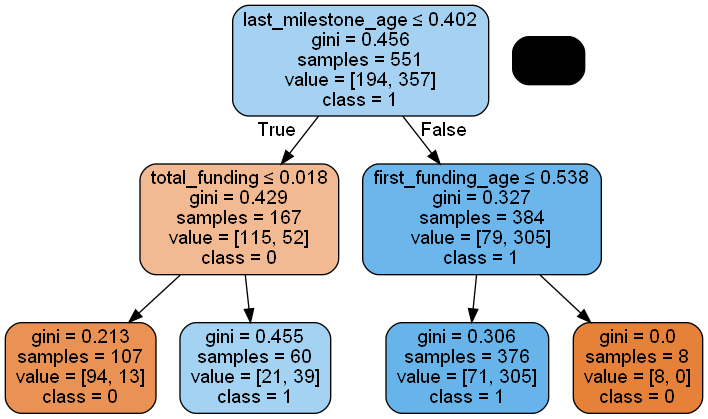

In [27]:
presentTree(dt_random.best_estimator_, X)

In [28]:
dt_grid = GridSearchCV(estimator=base_tree_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

dt_grid.fit(X_train, y_train)

dt_models['grid'] = dt_grid.best_estimator_

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


In [29]:
dt_grid.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [30]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_tree_model, 'base'), (dt_grid.best_estimator_, 'grid'))

[base] model accuracy = 71.20%
[grid] model accuracy = 78.26%
Improvement of 9.92%


let's see the new tree

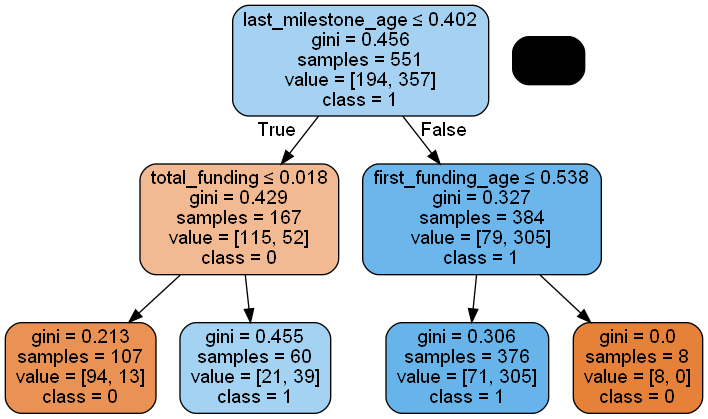

In [31]:
presentTree(dt_grid.best_estimator_, X)

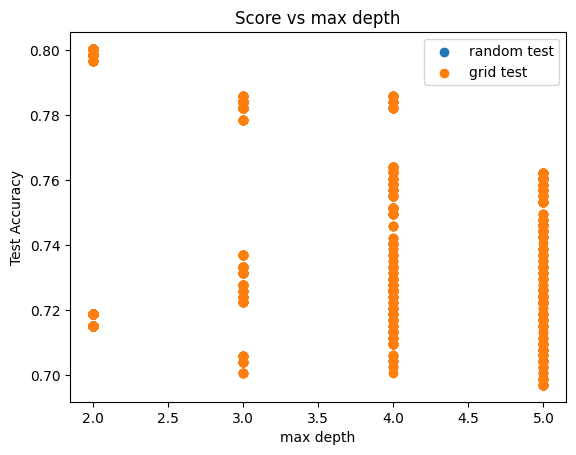

In [32]:
plot_hyper_search({'random': dt_random, 'grid': dt_grid}, 'max depth')

Now let's see the ROC curve and the AUC score of the decision tree model with this depth on the train set.

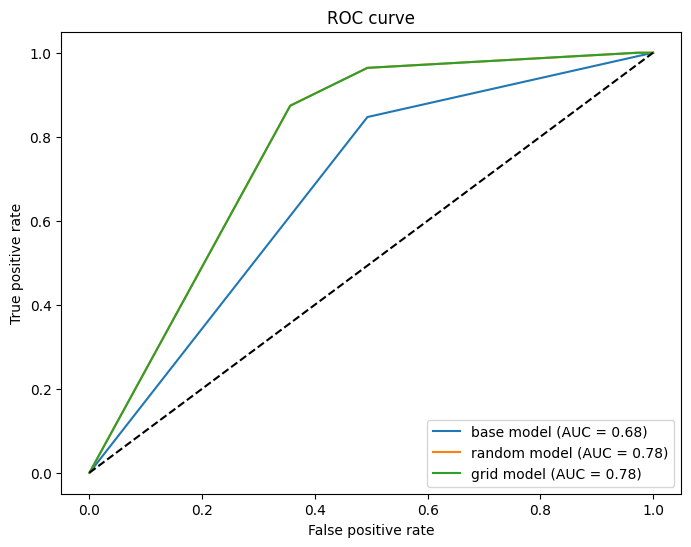

In [33]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_tree_model, 'base'), (dt_random.best_estimator_, 'random'), (dt_grid.best_estimator_, 'grid')])

We can see that the grid model got the best AUC.   
Now we will decide the best model according to the ttest.

T-test on metric accuracy	[pval=0.032] reject null hypothesis => random is BETTER THAN base
T-test on metric recall	[pval=0.032] reject null hypothesis => random is BETTER THAN base
T-test on metric precision	[pval=0.033] reject null hypothesis => random is BETTER THAN base
T-test on metric f-score	[pval=0.015] reject null hypothesis => random is BETTER THAN base
T-test on metric accuracy	[pval=0.032] reject null hypothesis => grid is BETTER THAN base
T-test on metric recall	[pval=0.032] reject null hypothesis => grid is BETTER THAN base
T-test on metric precision	[pval=0.033] reject null hypothesis => grid is BETTER THAN base
T-test on metric f-score	[pval=0.015] reject null hypothesis => grid is BETTER THAN base
T-test on metric accuracy	No p-value accept null hypothesis => No one of random and grid is better than the other
T-test on metric recall	No p-value accept null hypothesis => No one of random and grid is better than the other
T-test on metric precision	No p-value accept null 

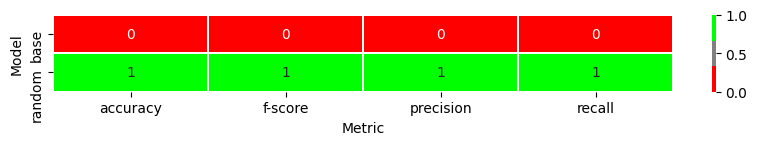

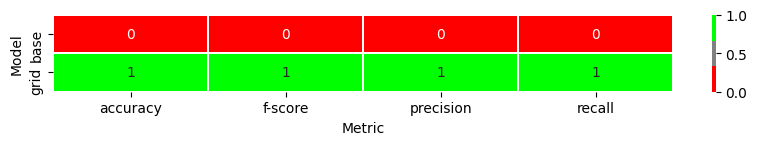

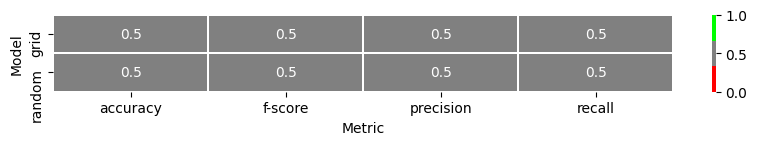

In [40]:
dt_models_metrics = {n: evaluate(X, y, m) for n, m in dt_models.items()}

ttest_all_metrics(dt_models_metrics)

Overall the random and grid models are better than the classic model, and no difference between them.
So we will choose the grid model.

In [41]:
print_metrics(dt_models_metrics['grid'])

Confusion table of (test) best fold:


0   1
0  29  23
1   4  91

Metrics for train set:


Metrics for test set:


### [B] RandomForest Classifier 

In [42]:
def findBestNumTrees(X, y):
    jmps = 5
    start = 10
    values = list(range(start, 85, jmps))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    
    for k in values:
        clf = RandomForestClassifier(n_estimators=k, random_state=RAND)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(values, train_scores)
    plt.plot(values, test_scores)
    plt.xticks(values)
    plt.legend(['train', 'test'])
    plt.xlabel('best num of trees')
    plt.ylabel('accuracy')
    plt.show()
    
    return np.argmax(test_scores)*jmps + start, test_scores[np.argmax(test_scores)]

In [43]:
base_rf_model = RandomForestClassifier(random_state=RAND)

In [44]:
print_metrics(evaluate(X, y, base_rf_model))

Confusion table of (test) best fold:


0   1
0  34  18
1   8  87

Metrics for train set:


Metrics for test set:


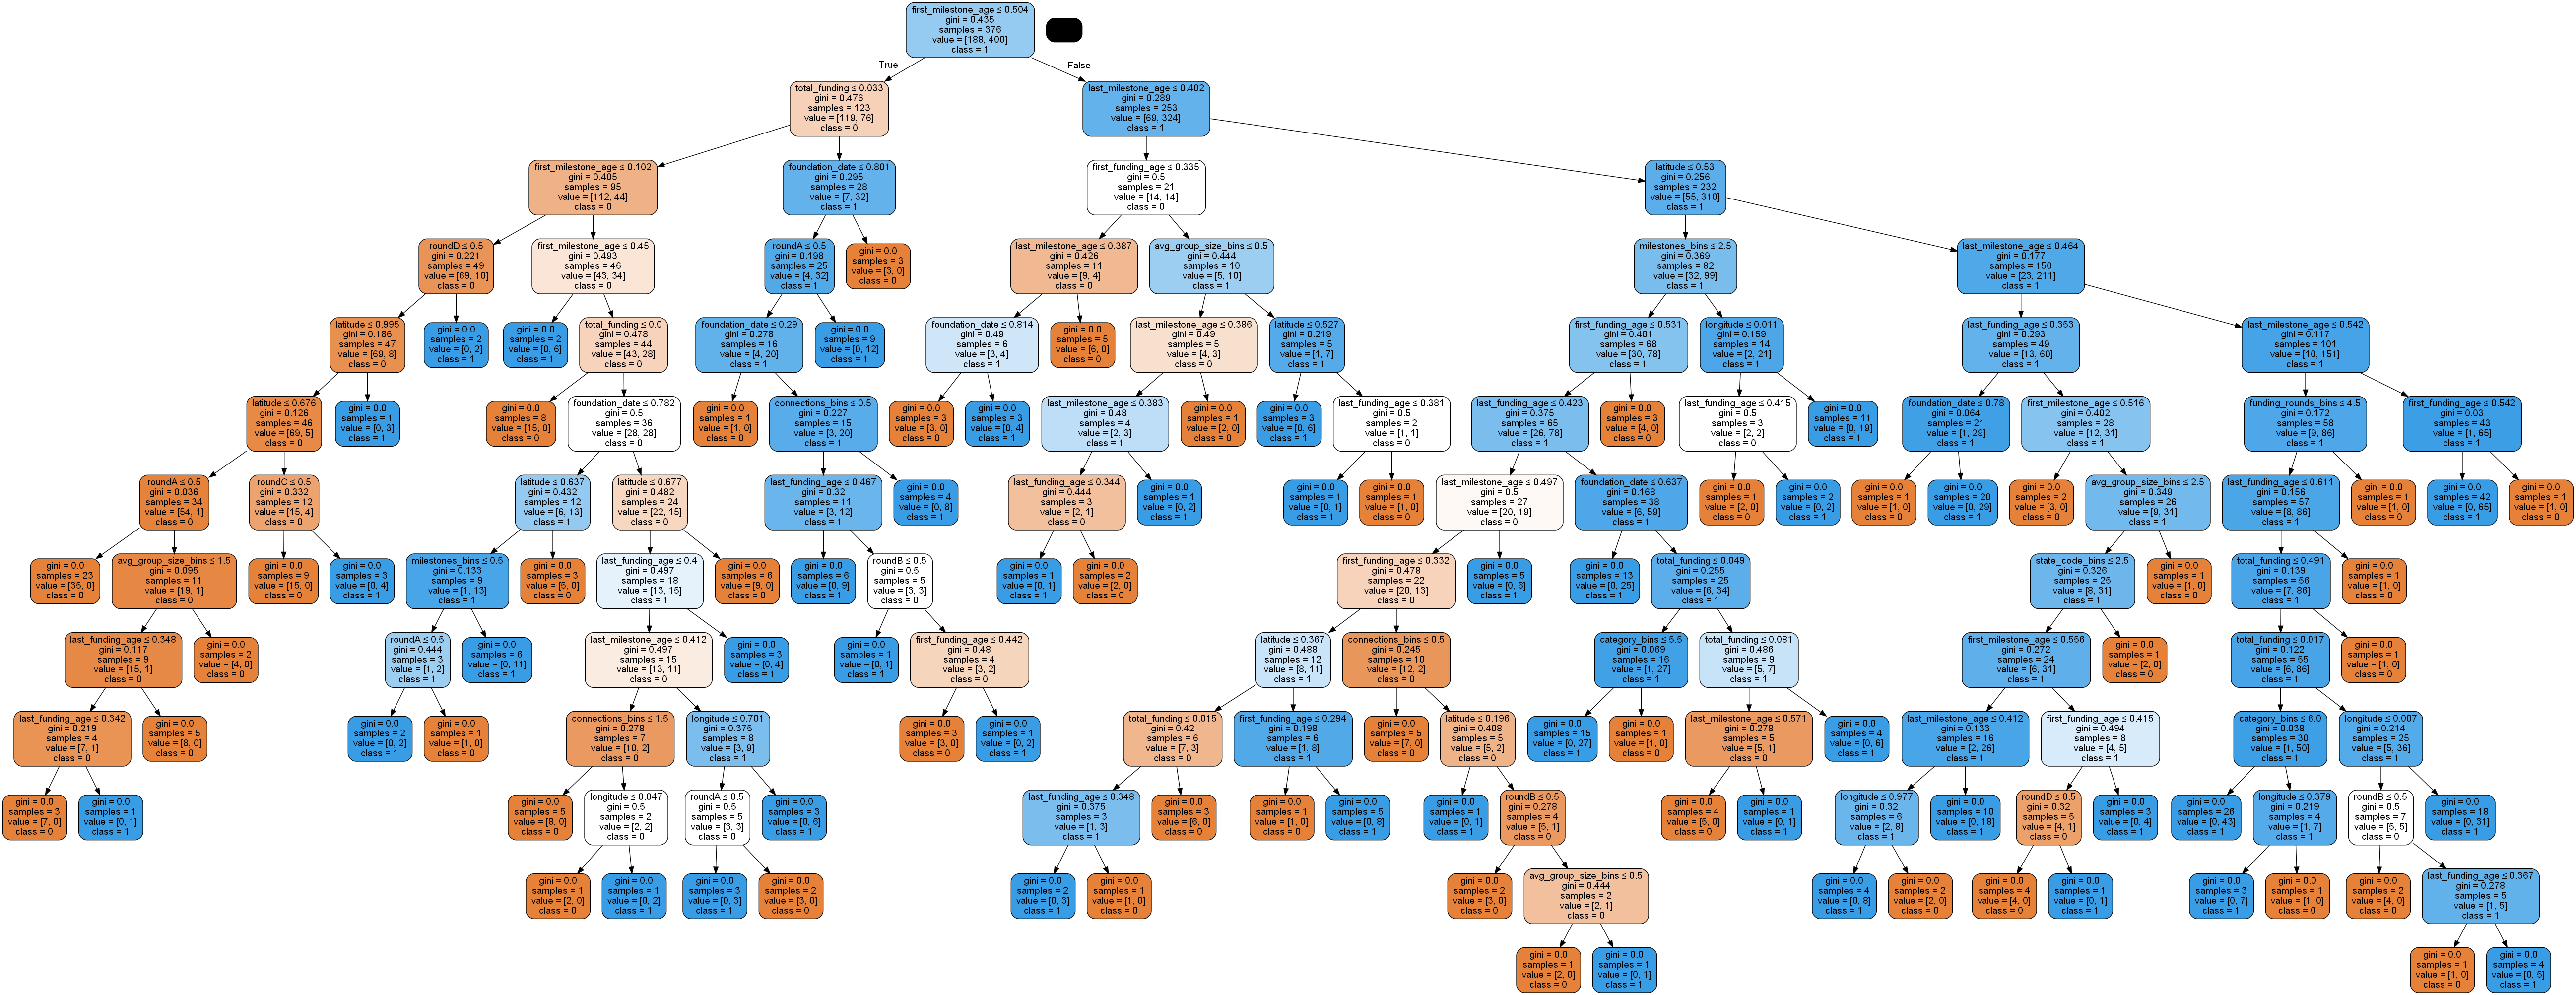

In [45]:
presentTree(base_rf_model.estimators_[0], X)

Just like before, we got overfitting, so let's try to find the best hyper-parameters for the random forest model. We'll start from number of trees.

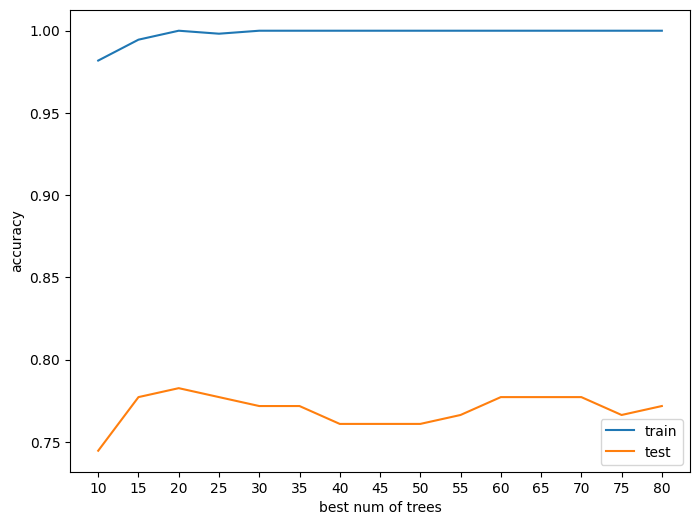

The best number of trees is 20 with accuracy of 0.782608695652174


In [46]:
best_num, best_num_acc = findBestNumTrees(X, y)
print(f'The best number of trees is {best_num} with accuracy of {best_num_acc}')

In [47]:
print_metrics(evaluate(X, y, clf=RandomForestClassifier(n_estimators=best_num, random_state=RAND)))

Confusion table of (test) best fold:


0   1
0  33  19
1  13  82

Metrics for train set:


Metrics for test set:


Again decent accuracy (and overfitting), so we'll try to improve it using hyperparameter tuning.

In [48]:
rf_models = {'base': base_rf_model, 'random': None, 'grid': None}

In [49]:
base_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [50]:
n_estimators = [x for x in range(10, 120, 11)] + [802]
max_features = ['sqrt', 'log2', 2, 5, 7]
max_depth = [int(x) for x in range(2, 8)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 3, 5, 10]
max_samples = [0.3, 0.5, 0.7]
max_samples.append(None)

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples,
               'criterion': ['gini', 'entropy']}

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

rf_random = RandomizedSearchCV(estimator=base_rf_model, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=2, random_state=RAND, n_jobs=-1)

rf_random.fit(X_train, y_train)

rf_models['random'] = rf_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [52]:
rf_random.best_params_

{'n_estimators': 43,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_samples': None,
 'max_features': 7,
 'max_depth': 3,
 'criterion': 'entropy'}

In [53]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_rf_model, 'base'), (rf_random.best_estimator_, 'random'))

[base] model accuracy = 76.63%
[random] model accuracy = 76.63%
Improvement of 0.00%


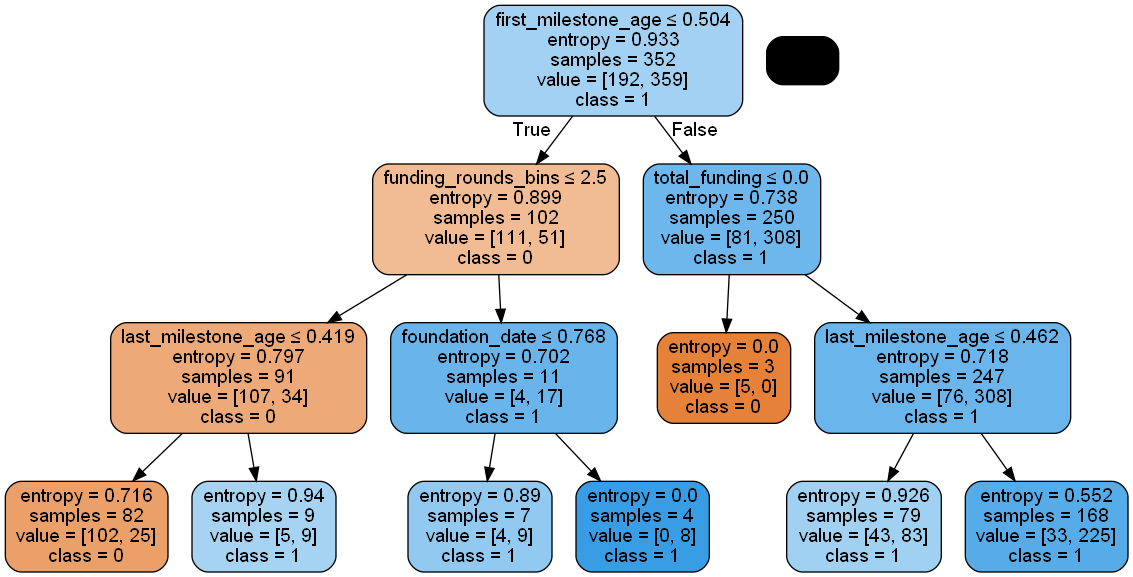

In [54]:
presentTree(rf_random.best_estimator_.estimators_[0], X)

In [55]:
n_estimators = [x for x in range(32, 60, 11)]
max_features = ['sqrt', 2]
max_depth = [int(x) for x in range(2, 4)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 3]
max_samples = [0.5]
max_samples.append(None)

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples,
               'criterion': ['gini', 'entropy']}

In [56]:
rf_grid = GridSearchCV(estimator=base_rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

rf_grid.fit(X_train, y_train)
rf_models['grid'] = rf_grid.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [57]:
rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_samples': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 43}

In [58]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_rf_model, 'base'), (rf_grid.best_estimator_, 'grid'))

[base] model accuracy = 76.63%
[grid] model accuracy = 77.72%
Improvement of 1.42%


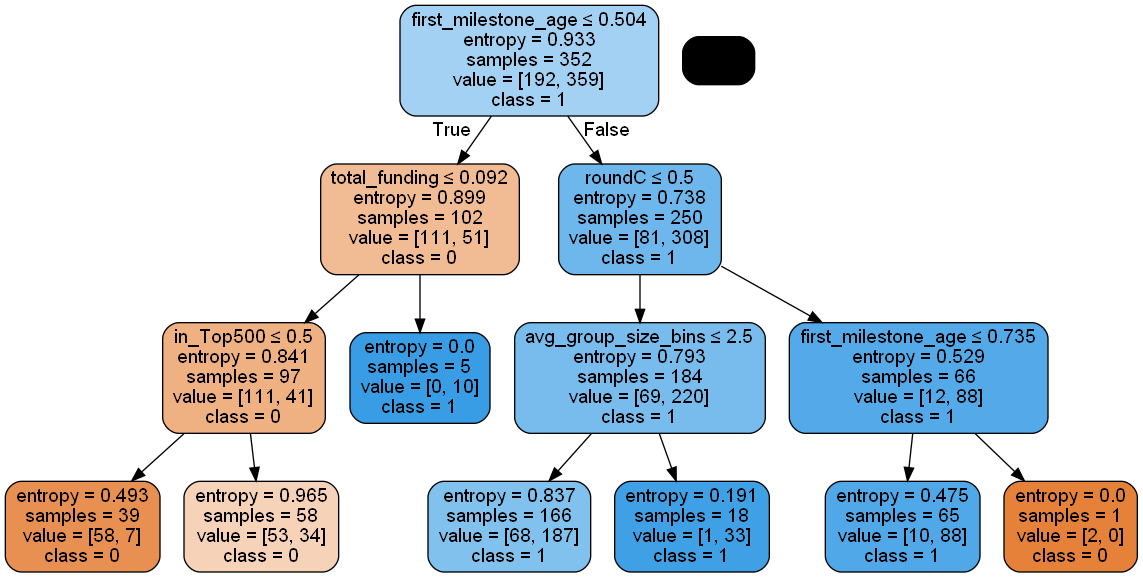

In [59]:
presentTree(rf_grid.best_estimator_.estimators_[0], X)

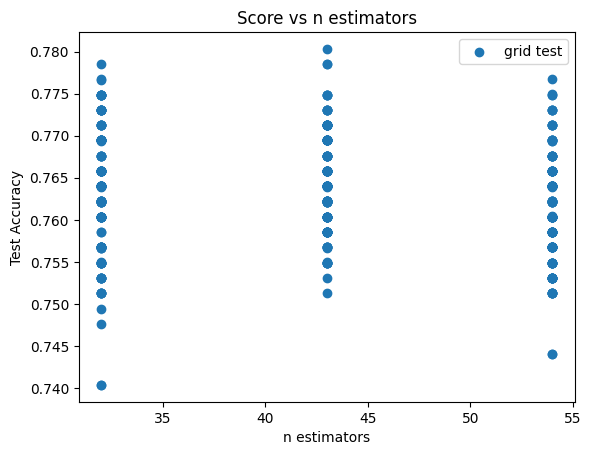

In [119]:
plot_hyper_search({'grid': rf_grid}, 'n estimators')

Overall we saw that the grid has the best accuracy, but let's also see the AUC and ttest. 

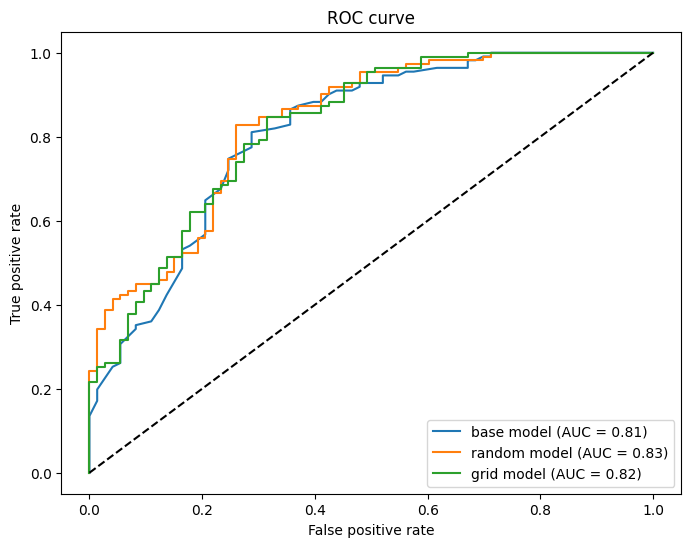

In [60]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_rf_model, 'base'), (rf_random.best_estimator_, 'random'), (rf_grid.best_estimator_, 'grid')])

T-test on metric accuracy	[pval=0.546] accept null hypothesis => No one of base and random is better than the other
T-test on metric recall	[pval=0.546] accept null hypothesis => No one of base and random is better than the other
T-test on metric precision	[pval=0.767] accept null hypothesis => No one of base and random is better than the other
T-test on metric f-score	[pval=0.841] accept null hypothesis => No one of base and random is better than the other
T-test on metric accuracy	[pval=0.923] accept null hypothesis => No one of base and grid is better than the other
T-test on metric recall	[pval=0.923] accept null hypothesis => No one of base and grid is better than the other
T-test on metric precision	[pval=0.835] accept null hypothesis => No one of base and grid is better than the other
T-test on metric f-score	[pval=0.783] accept null hypothesis => No one of base and grid is better than the other
T-test on metric accuracy	[pval=0.235] accept null hypothesis => No one of random an

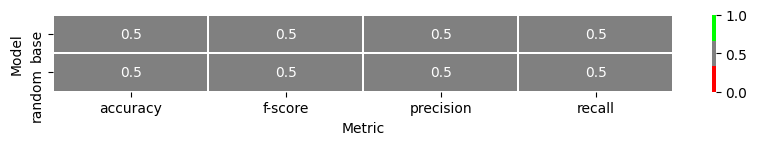

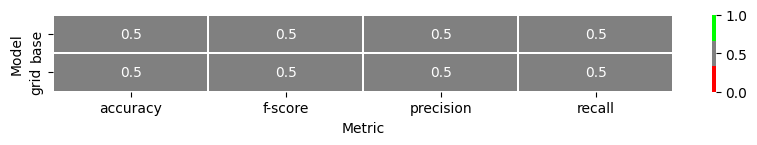

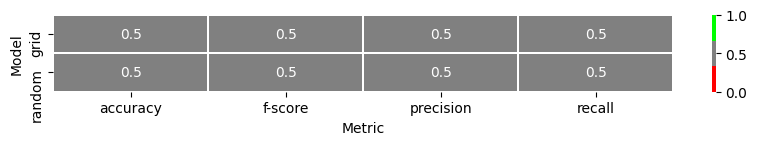

In [61]:
rf_models_metrics = {n: evaluate(X, y, m) for n, m in rf_models.items()}
ttest_all_metrics(rf_models_metrics)

In [62]:
print_metrics(evaluate(X, y, rf_models['grid']))

Confusion table of (test) best fold:


0   1
0  33  19
1  10  85

Metrics for train set:


Metrics for test set:


### [C] Naïve Bayes Classifier

In this section, the Naïve Bayes Classifier will be studied on our data.
Note that when using the Naïve Bayes Classifier, we assume out features are independant!

Starting with the very basic model:

In [63]:
base_bays_model = GaussianNB()
print_metrics(evaluate(X, y, base_bays_model))

Confusion table of (test) best fold:


0   1
0  32  20
1  15  80

Metrics for train set:


Metrics for test set:


A second try, on the **dummies**:

In [64]:
print_metrics(evaluate(Xd, Yd, base_bays_model))

Confusion table of (test) best fold:


0   1
0  40  12
1  31  64

Metrics for train set:


Metrics for test set:


Dummy performance isn't great.   
We will try to tweak the different parameters in order to find a better configuration:

In [65]:
base_bays_model.get_params()

{'priors': None, 'var_smoothing': 1e-09}

let's try different variable smoothings:

In [66]:
def findBestAlpha(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    options = [10**k for k in range(0, -10, -1)]
    for alpha in options:
        clf = GaussianNB(var_smoothing=alpha)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.semilogx(options, train_scores)
    plt.semilogx(options, test_scores)
    plt.xticks(options)
    plt.legend(['train', 'test'])
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.show()
    
    # search_on = [test - train for train, test in zip(train_scores, test_scores)]
    arg_best = np.argmax(test_scores)
    return arg_best, test_scores[arg_best]

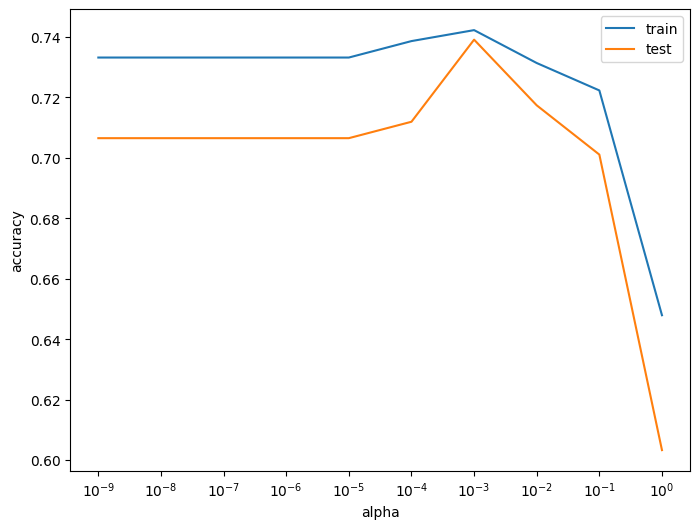

The best alpha is 10^-2 with accuracy of 0.739


In [67]:
best_alpha, best_acc = findBestAlpha(X, y)
print(f'The best alpha is 10^-{best_depth} with accuracy of {best_acc:0.3f}')

In [68]:
best_alpha_model = GaussianNB(var_smoothing=pow(10, -best_alpha))

In [69]:
nb_models = {'base': base_bays_model, 'best_alpha': best_alpha_model}

In [70]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_bays_model, 'base'), (nb_models['best_alpha'], 'best_alpha'))

[base] model accuracy = 70.65%
[best_alpha] model accuracy = 73.91%
Improvement of 4.62%


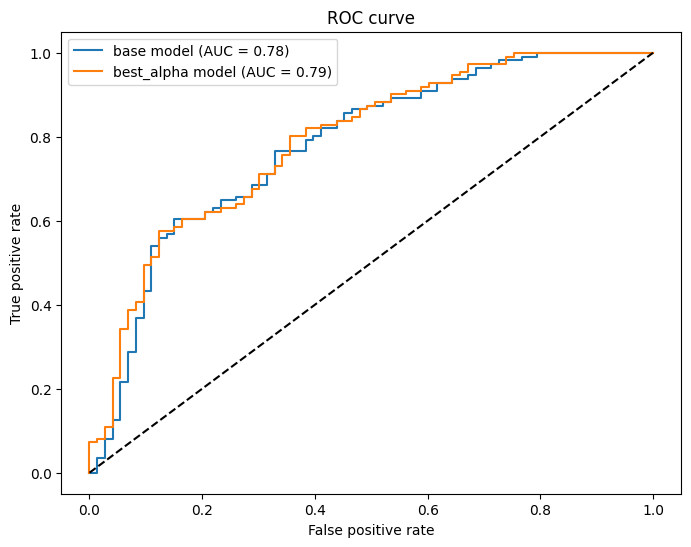

In [71]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_bays_model, 'base'), (nb_models['best_alpha'], 'best_alpha')])

T-test on metric accuracy	[pval=0.468] accept null hypothesis => No one of base and best_alpha is better than the other
T-test on metric recall	[pval=0.468] accept null hypothesis => No one of base and best_alpha is better than the other
T-test on metric precision	[pval=0.612] accept null hypothesis => No one of base and best_alpha is better than the other
T-test on metric f-score	[pval=0.264] accept null hypothesis => No one of base and best_alpha is better than the other


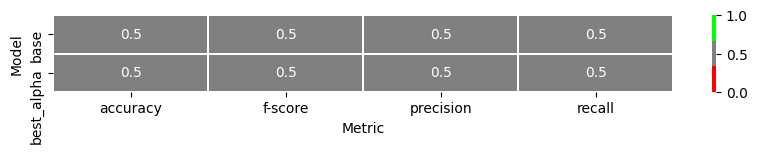

In [72]:
nb_models_metrics = {name: evaluate(X, y, model) for name, model in nb_models.items()}
ttest_all_metrics(nb_models_metrics)

We can see that we don't have any statistical significance between the different models, but we did saw that the model with the best alpha is the one with the best accuracy, so we'll choose it.

In [73]:
print_metrics(evaluate(X, y, nb_models['best_alpha']))

Confusion table of (test) best fold:


0   1
0  32  20
1  13  82

Metrics for train set:


Metrics for test set:


### [D] SVM Classifier

In [74]:
base_svm_model = svm.SVC(random_state=RAND, probability=True)
print_metrics(evaluate(X, y, base_svm_model))

Confusion table of (test) best fold:


0   1
0  26  26
1   7  88

Metrics for train set:


Metrics for test set:


Accuracy isn't the best, so we'll try to improve it by using hyperparameter tuning.

In [75]:
base_svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

First let's check if the 'C' parameter has an effect on the accuracy.

In [76]:
def findBestC(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    options = [x / 100 for x in range(1, 200, 10)]
    for C in options:
        clf = svm.SVC(C=C, random_state=RAND)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(options, train_scores)
    plt.plot(options, test_scores)
    plt.legend(['train', 'test'])
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.show()
    
    arg_best = np.argmax(test_scores)
    return round(arg_best/10, 2), test_scores[arg_best]

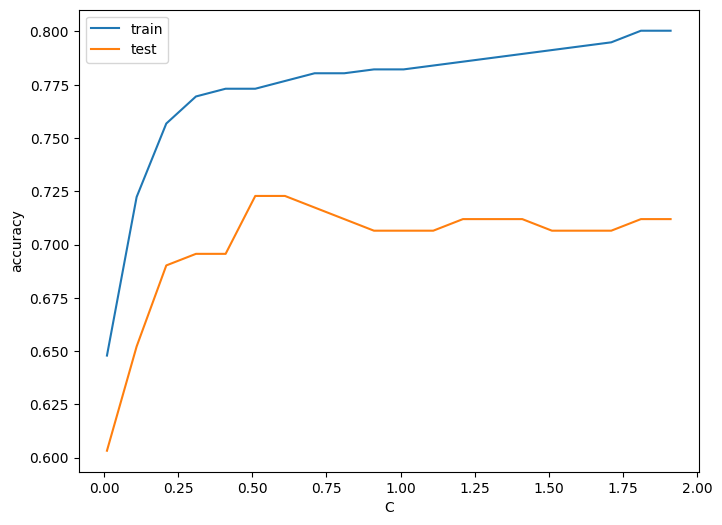

The best C is 0.5 with accuracy of 0.723


In [77]:
best_c, best_c_acc = findBestC(X, y)
print(f'The best C is {best_c} with accuracy of {best_c_acc:0.3f}')

Now let's do a hyperparameter tuning for the SVM model - using random and grid search.

In [78]:
svm_models = {'base': base_svm_model, 'random': None, 'grid': None}

In [79]:
param_grid = {'C': [best_c + i / 10 for i in range(0, 6)],
               'kernel': ['linear', 'rbf', 'sigmoid'],  # , 'poly'
               'gamma': ['scale'],  # , 'auto'
               'degree': [2, 3, 4, 5], 
               'coef0': [0.0, 0.1, 0.2, 0.3, 0.4], 
               'probability': [True]}

In [80]:
svm_random = RandomizedSearchCV(estimator=base_svm_model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2)

svm_random.fit(X_train, y_train)
svm_models['random'] = svm_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [81]:
svm_random.best_params_

{'probability': True,
 'kernel': 'rbf',
 'gamma': 'scale',
 'degree': 3,
 'coef0': 0.1,
 'C': 1.0}

In [82]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_svm_model, 'base'), (svm_random.best_estimator_, 'random'))

[base] model accuracy = 70.65%
[random] model accuracy = 70.65%
Improvement of 0.00%


In [83]:
svm_grid = GridSearchCV(estimator=base_svm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

svm_grid.fit(X_train, y_train)
svm_models['grid'] = svm_grid.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [84]:
svm_grid.best_params_

{'C': 1.0,
 'coef0': 0.0,
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'probability': True}

In [85]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_svm_model, 'base'), (svm_grid.best_estimator_, 'grid'))

[base] model accuracy = 70.65%
[grid] model accuracy = 70.65%
Improvement of 0.00%


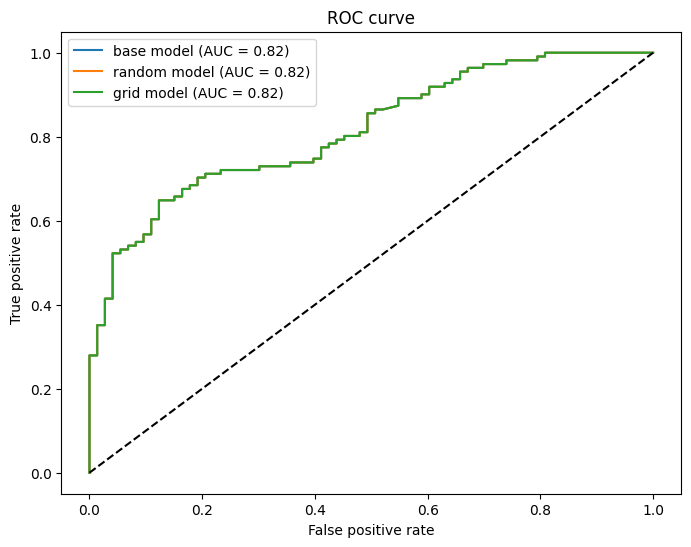

In [86]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_svm_model, 'base'), (svm_random.best_estimator_, 'random'), (svm_grid.best_estimator_, 'grid')])

T-test on metric accuracy	No p-value accept null hypothesis => No one of base and random is better than the other
T-test on metric recall	No p-value accept null hypothesis => No one of base and random is better than the other
T-test on metric precision	No p-value accept null hypothesis => No one of base and random is better than the other
T-test on metric f-score	No p-value accept null hypothesis => No one of base and random is better than the other
T-test on metric accuracy	No p-value accept null hypothesis => No one of base and grid is better than the other
T-test on metric recall	No p-value accept null hypothesis => No one of base and grid is better than the other
T-test on metric precision	No p-value accept null hypothesis => No one of base and grid is better than the other
T-test on metric f-score	No p-value accept null hypothesis => No one of base and grid is better than the other
T-test on metric accuracy	No p-value accept null hypothesis => No one of random and grid is better t

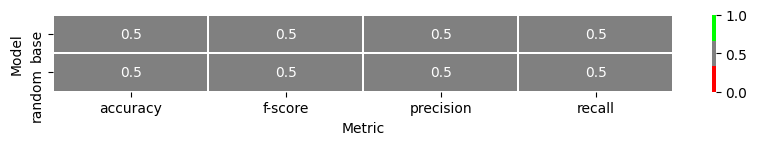

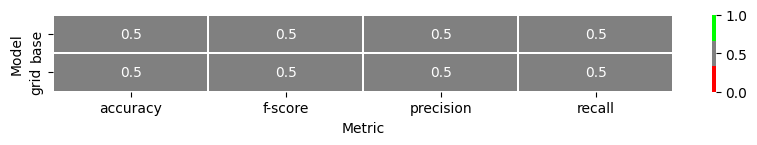

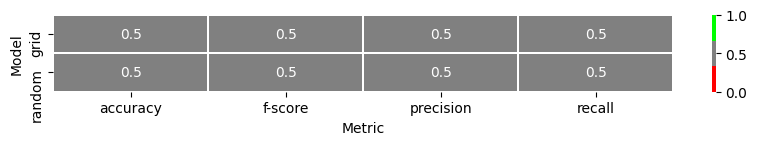

In [87]:
svm_models_metrics = {name: evaluate(X, y, model) for name, model in svm_models.items()}

ttest_all_metrics(svm_models_metrics)

In [88]:
print_metrics(evaluate(X, y, svm_models['grid']))

Confusion table of (test) best fold:


0   1
0  26  26
1   7  88

Metrics for train set:


Metrics for test set:


### [E] K-NN Classifier 

In [89]:
def findBestK(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    for k in range(1, 11):
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), train_scores)
    plt.plot(range(1, 11), test_scores)
    plt.legend(['train', 'test'])
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.show()
    
    arg_best = np.argmax(test_scores)
    return arg_best + 1, test_scores[arg_best]

In [90]:
base_knn_model = KNeighborsClassifier()

In [91]:
print_metrics(evaluate(X, y, base_knn_model))

Confusion table of (test) best fold:


0   1
0  28  24
1  12  83

Metrics for train set:


Metrics for test set:


Same as before, we'll try to find the best hyper-parameters for the K-NN model.

First let's check the effect of 'n_neighbors' parameter on the accuracy.

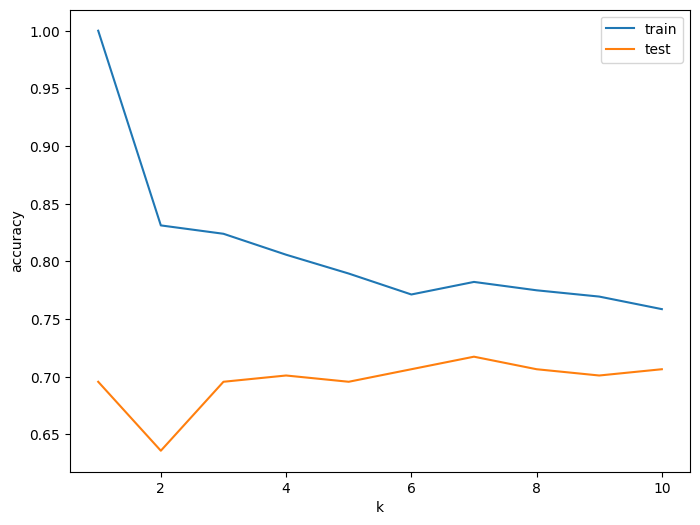

The best k is 7 with accuracy of 0.717


In [92]:
best_k, best_k_acc = findBestK(X, y)
print(f'The best k is {best_k} with accuracy of {best_k_acc:0.3f}')

Now let's do a hyperparameter tuning for the K-NN model - using random and grid search.

In [93]:
knn_models = {'base': base_knn_model, 'random': None, 'grid': None}

In [94]:
base_knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [95]:
algs = ['ball_tree', 'kd_tree', 'brute']
 
# all_mtrcs = [set(sklearn.neighbors.VALID_METRICS[x]) for x in algs]
# unique_mtrcs= set()
# for x in all_mtrcs:
#     unique_mtrcs |= x
 
survivers = ['euclidean', 'cosine', 'haversine', 'infinity', 'manhattan']
        
param_grid = { 'algorithm': algs,
               'leaf_size': list(range(20, 91, 7)),
               'metric': survivers,  
               'n_neighbors': list(range(4, 21)),
               'weights': ['uniform', 'distance']}

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

knn_random = RandomizedSearchCV(estimator=base_knn_model, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=5, random_state=RAND, n_jobs=-1)

knn_random.fit(X_train, y_train)

knn_models['random'] = knn_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\nei

In [97]:
knn_random.best_params_

{'weights': 'uniform',
 'n_neighbors': 17,
 'metric': 'manhattan',
 'leaf_size': 90,
 'algorithm': 'kd_tree'}

In [98]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_knn_model, 'base'), (knn_random.best_estimator_, 'random'))

[base] model accuracy = 69.57%
[random] model accuracy = 70.65%
Improvement of 1.56%


In [99]:
knn_grid = GridSearchCV(estimator=base_knn_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

knn_grid.fit(X_train, y_train)

knn_models['grid'] = knn_grid.best_estimator_

Fitting 5 folds for each of 5610 candidates, totalling 28050 fits


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9350 fits failed out of a total of 28050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1870 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklear

In [100]:
knn_grid.best_params_

{'algorithm': 'brute',
 'leaf_size': 20,
 'metric': 'cosine',
 'n_neighbors': 7,
 'weights': 'uniform'}

In [101]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_knn_model, 'base'), (knn_grid.best_estimator_, 'grid'))

[base] model accuracy = 69.57%
[grid] model accuracy = 67.93%
Improvement of -2.34%


For some reason the grid didn't find the best parameters, so we'll use params closer to the random anf try again.

In [102]:
param_grid = { 'algorithm': algs[1:],
               'leaf_size': list(range(90, 101, 7)),
               'metric': ['euclidean', 'infinity', 'manhattan'],  
               'n_neighbors': list(range(10, 18)),
               'weights': ['uniform', 'distance']}

In [103]:
knn_grid2 = GridSearchCV(estimator=base_knn_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

knn_grid2.fit(X_train, y_train)

# knn_models['grid'] = knn_grid.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ne

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['kd_tree', 'brute'],
                         'leaf_size': [90, 97],
                         'metric': ['euclidean', 'infinity', 'manhattan'],
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [104]:
knn_grid2.best_params_

{'algorithm': 'kd_tree',
 'leaf_size': 90,
 'metric': 'manhattan',
 'n_neighbors': 11,
 'weights': 'uniform'}

In [105]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_knn_model, 'base'), (knn_grid2.best_estimator_, 'grid'))

[base] model accuracy = 69.57%
[grid] model accuracy = 70.65%
Improvement of 1.56%


In [106]:
knn_models['grid'] = knn_grid2.best_estimator_

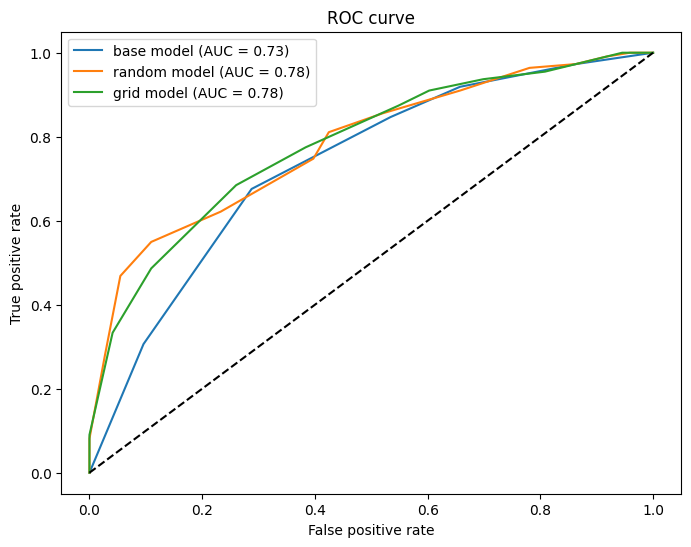

In [107]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_knn_model, 'base'), (knn_random.best_estimator_, 'random'), (knn_grid2.best_estimator_, 'grid')])

T-test on metric accuracy	[pval=0.012] reject null hypothesis => random is BETTER THAN base
T-test on metric recall	[pval=0.012] reject null hypothesis => random is BETTER THAN base
T-test on metric precision	[pval=0.025] reject null hypothesis => random is BETTER THAN base
T-test on metric f-score	[pval=0.022] reject null hypothesis => random is BETTER THAN base
T-test on metric accuracy	[pval=0.017] reject null hypothesis => grid is BETTER THAN base
T-test on metric recall	[pval=0.017] reject null hypothesis => grid is BETTER THAN base
T-test on metric precision	[pval=0.042] reject null hypothesis => grid is BETTER THAN base
T-test on metric f-score	[pval=0.009] reject null hypothesis => grid is BETTER THAN base
T-test on metric accuracy	[pval=0.784] accept null hypothesis => No one of random and grid is better than the other
T-test on metric recall	[pval=0.784] accept null hypothesis => No one of random and grid is better than the other
T-test on metric precision	[pval=0.724] accept

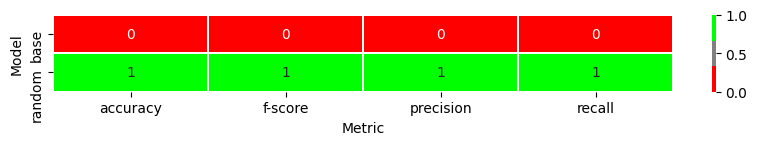

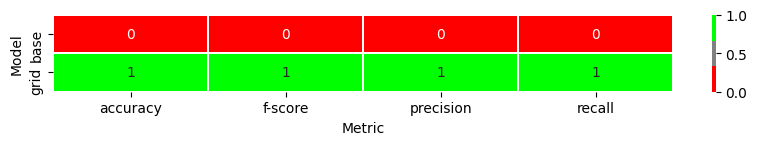

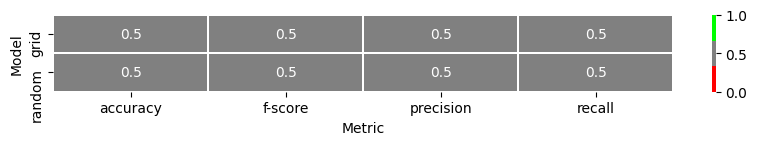

In [108]:
knn_models_metrics = {name: evaluate(X, y, model) for name, model in knn_models.items()}
ttest_all_metrics(knn_models_metrics)

### Selecting the best model

In [109]:
def plot_metrics(models_metrics):
    our_metrics = ['accuracy', 'precision', 'recall', 'f-score']
    df_mean_metrics = pd.DataFrame(columns=our_metrics)
    
    for name, metrics in models_metrics.items():
        df_mean_metrics = pd.concat([df_mean_metrics, pd.DataFrame({metric: np.mean(metrics[metric][1]) for metric in our_metrics}, index=[name])], axis=0)

    # now only need to present this dataframe in a bar plot for each metric in different 
    fig, axes = plt.subplots(2, 2, figsize=(18, 12.5))
    fig.suptitle("Metrics comparison")
    for idx, metric in enumerate(our_metrics):
        i1, i2 = divmod(idx, 2)
        df_mean_metrics[metric].plot(kind='bar', color=[(x/10.0, x/20.0, 0.75) for x in range(0, 10, 2)], ax=axes[i1, i2])
        axes[i1, i2].set_title(f'{metric} comparison')
        axes[i1, i2].set_xlabel('Model')
        axes[i1, i2].set_xlabel(metric)
        # plt.xlabel('Model')
        # plt.ylabel(metric)
    plt.show()

In [110]:
our_models = {'DT': dt_models['grid'], 'RF': rf_models['grid'], 'NB': nb_models['best_alpha'], 'SVM': svm_models['grid'], 'KNN': knn_models['grid']}

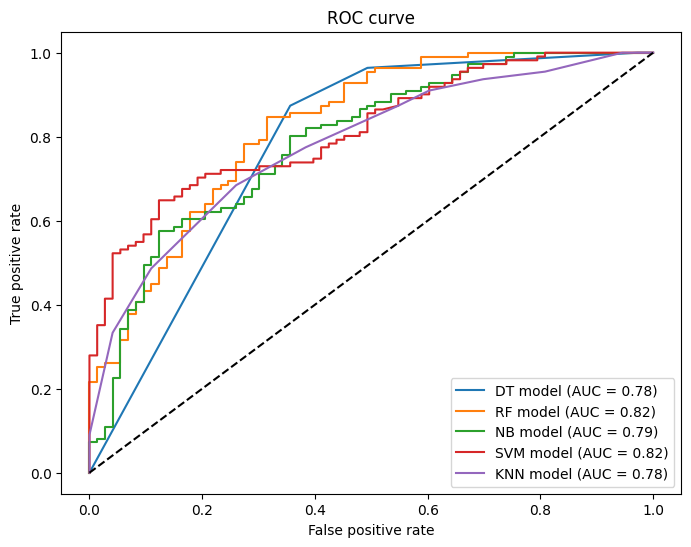

In [111]:
_ = createROC(X_train, y_train, X_test, y_test, [(model, name) for name, model in our_models.items()])

In [112]:
our_models_metrics = {name: evaluate(X, y, model) for name, model in our_models.items()}

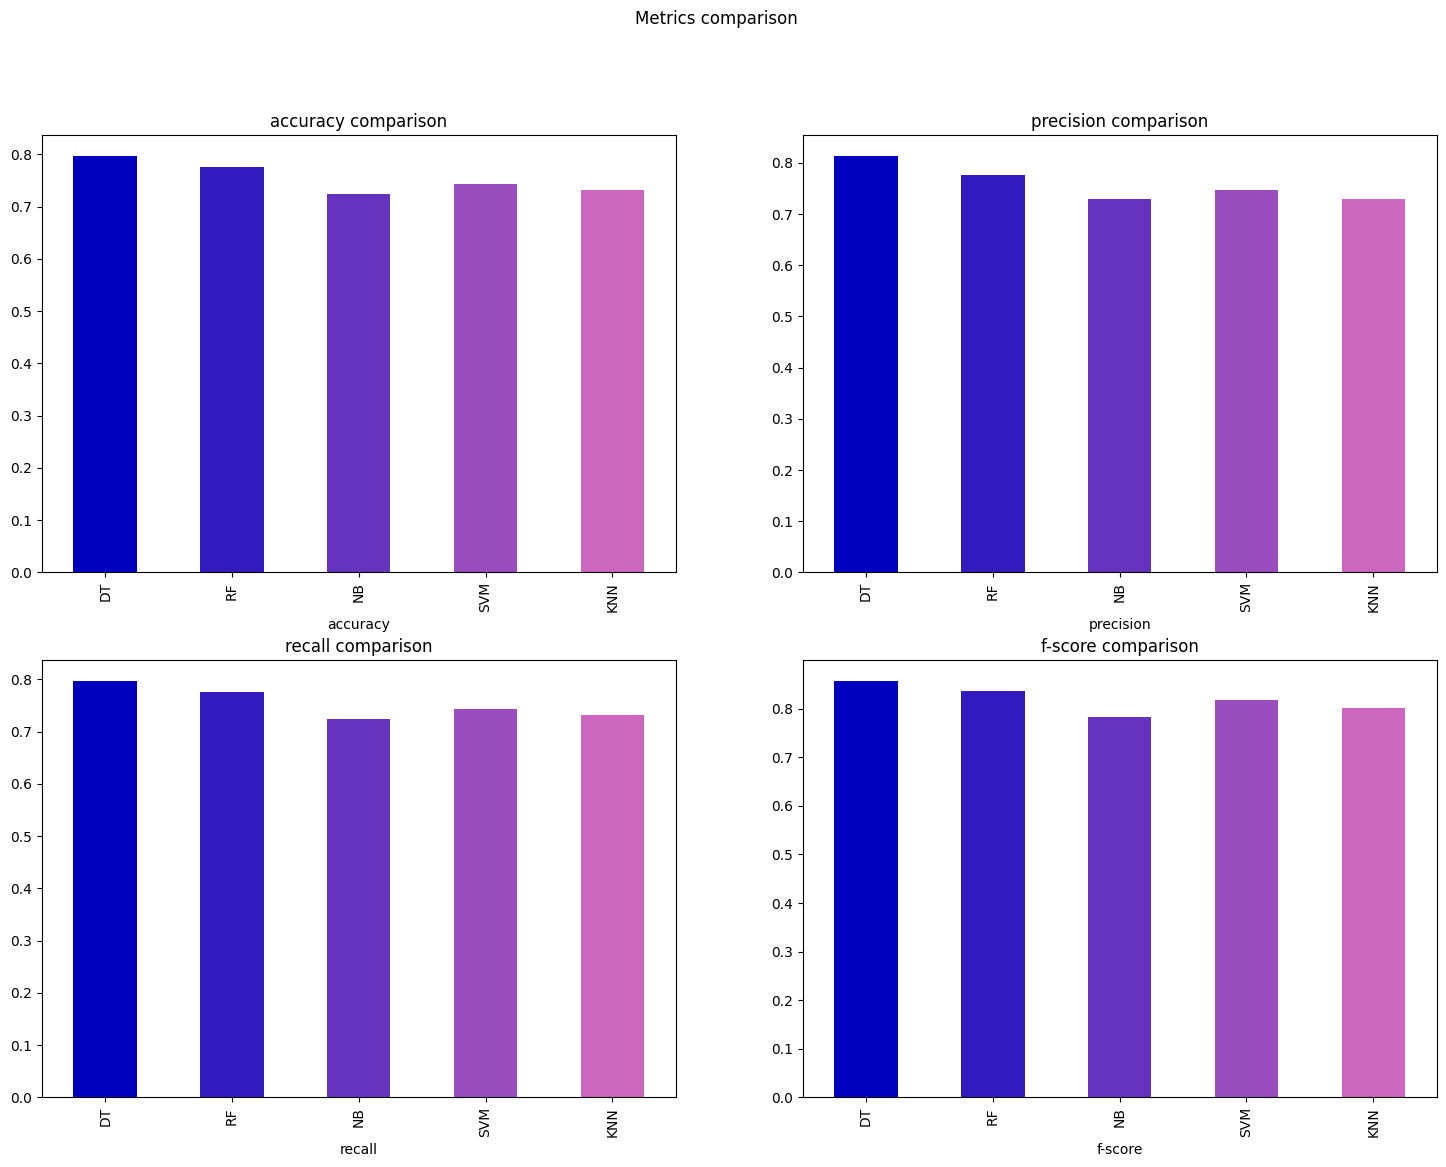

In [113]:
plot_metrics(our_models_metrics)

T-test on metric accuracy	[pval=0.040] reject null hypothesis => DT is BETTER THAN RF
T-test on metric recall	[pval=0.040] reject null hypothesis => DT is BETTER THAN RF
T-test on metric precision	[pval=0.018] reject null hypothesis => DT is BETTER THAN RF
T-test on metric f-score	[pval=0.019] reject null hypothesis => DT is BETTER THAN RF


T-test on metric accuracy	[pval=0.032] reject null hypothesis => DT is BETTER THAN NB
T-test on metric recall	[pval=0.032] reject null hypothesis => DT is BETTER THAN NB
T-test on metric precision	[pval=0.005] reject null hypothesis => DT is BETTER THAN NB
T-test on metric f-score	[pval=0.018] reject null hypothesis => DT is BETTER THAN NB
T-test on metric accuracy	[pval=0.054] accept null hypothesis => No one of DT and SVM is better than the other
T-test on metric recall	[pval=0.054] accept null hypothesis => No one of DT and SVM is better than the other
T-test on metric precision	[pval=0.043] reject null hypothesis => DT is BETTER THAN SVM
T-test on metric f-score	[pval=0.056] accept null hypothesis => No one of DT and SVM is better than the other
T-test on metric accuracy	[pval=0.051] accept null hypothesis => No one of DT and KNN is better than the other
T-test on metric recall	[pval=0.051] accept null hypothesis => No one of DT and KNN is better than the other
T-test on metric pre

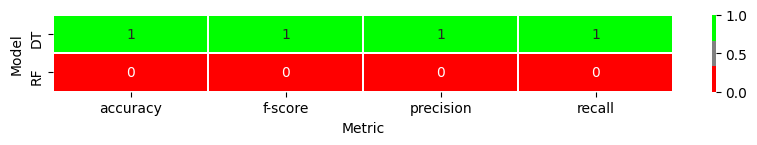

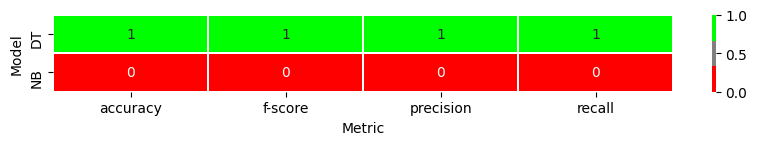

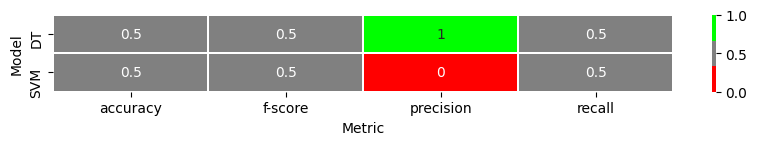

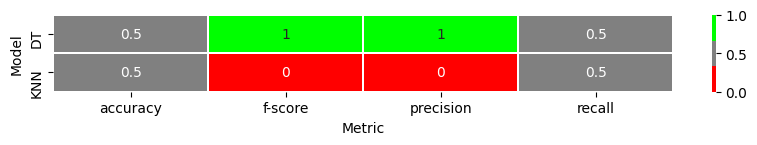

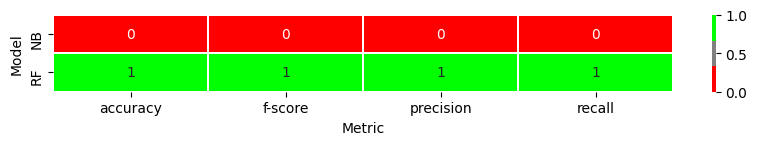

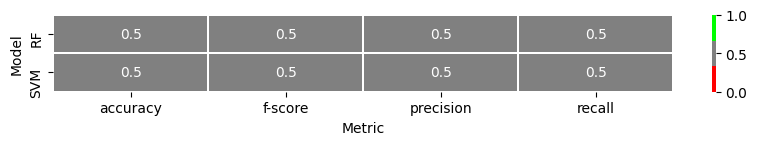

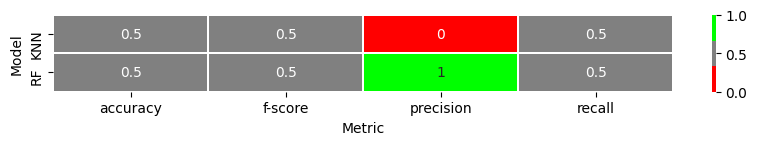

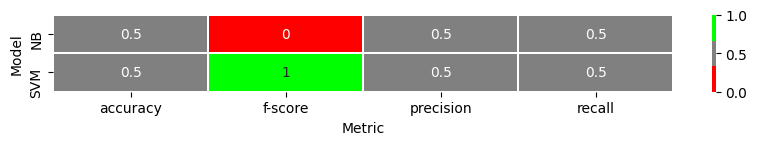

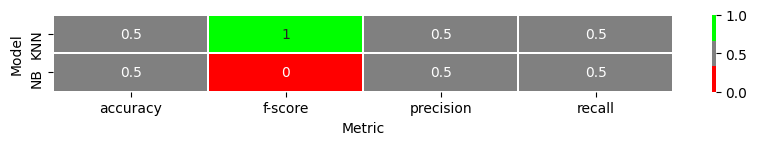

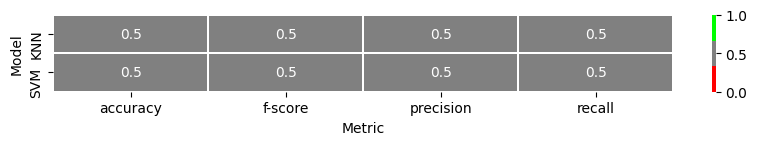

In [115]:
ttest_all_metrics(our_models_metrics)


Overall Decision Tree and Random Forest are the best models, but we'll choose the Decision Tree because it has the best accuracy.

In [122]:
y_pred_target = our_models['DT'].predict(df_test_clean)
output = pd.DataFrame(data=y_pred_target)
output.to_csv(f'Target.csv', index=False, header=False)

c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
